In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import holidays
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import statsmodels.api as sm 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, confusion_matrix, recall_score, precision_score, ConfusionMatrixDisplay
import math
import time 
 
%matplotlib inline 
%matplotlib notebook

In [2]:
def init_df(df):
    global len_df
    
    init_df = df
    
    print("\n##### Shape of df : ")
    print(init_df.shape)
    
    print("\n##### Number of df records: ")
    len_df = init_df.shape[0]
    print(len_df)
    
    print("\n##### Inital Column names\n")
    print(init_df.columns)
    init_df.rename(columns={'Parcel ID':'ParcelID','Suite/ Condo   #': 'SuiteCondo', 'Land Use':'LandUse', \
               'Property Address':'PropertyAddress','Property City':'PropertyCity','Sale Date':'SaleDate', \
              'Legal Reference':'LegalReference','Sold As Vacant':'SoldAsVacant', \
               'Multiple Parcels Involved in Sale':'MParcelsinSale', 'Tax District':'TaxDistrict', \
              'Land Value':'LandValue','Building Value':'BuildingValue','Finished Area' : 'FinishedArea',\
              'Foundation Type':'FoundationType', 'Year Built' : 'YearBuilt', 'Exterior Wall': 'ExteriorWall', \
              'Full Bath' : 'FuBath', 'Half Bath' : 'HaBath', 'Sale Price Compared To Value' : 'SPriceComparedValue'},\
             inplace=True)
    print("\n##### Changed Column names\n")
    print(init_df.columns)    
    
    display(init_df.head(3))
    
    init_df.info()
    
    display(pd.DataFrame(init_df.describe().transpose()))
    
    print("\n##### Check Null values in df\n")
    display(init_df.isnull().sum())
    
    print("\n##### Drop columns :'ParcelID','SuiteCondo', 'LegalReference' ")
    df = init_df.drop(labels = ['ParcelID','SuiteCondo', 'LegalReference','State'], axis=1)
    
    print("\n##### After Dropping columns : Column names \n")
    print(df.columns)
    
    print("\n##### After Dropping columns : Shape of df  \n")
    print(df.shape)
    
    return df

In [3]:
def conv_add(df):
    print("\nBefore converting : number of Unique addresses  \n", len(df['PropertyAddress'].unique()))
    df.replace({'PropertyAddress':{'\s+': '','\b+': '', '\d+' : ''}}, regex=True, inplace=True)
    print("\nAfter converting : number of Unique addresses \n", len(df['PropertyAddress'].unique()))
    return df

In [4]:
def fill_propretycity(df): #17529, 17696
    df.loc[df['PropertyCity'].isnull(),'PropertyCity'] = df['City']
    return df

In [5]:
def find_holiday(d):
    us_holidays = holidays.US()
    return int(d in us_holidays)

In [6]:
def find_Season(d):
    doy = d.timetuple().tm_yday
    spring = range(80, 172)
    summer = range(172, 264)
    fall = range(264, 355)

    if doy in spring:
        season = 0
    elif doy in summer:
        season = 1
    elif doy in fall:
        season = 2
    else:
        season = 3
    return season

In [7]:
def conv_date(df):
    print("\n## converting 'SaleDate' to 'Year', 'Month', 'Day', 'Season', 'Holiday'")
    
    df['SaleDate'] = pd.to_datetime(df['SaleDate'])
    
    df["Year"] = df["SaleDate"].apply(lambda x: x.year)
    df["Month"] = df["SaleDate"].apply(lambda x: x.month)
    df["Day"] = df["SaleDate"].apply(lambda x: x.day)
    df['Holiday'] = df['SaleDate'].apply(find_holiday)
    df['Season'] = df['SaleDate'].apply(find_Season)
    
    print("\n## Drop SaleDate")
    df.drop(['SaleDate'], axis=1, inplace=True)
    
    date_list = ["Year", "Month", "Day", "Holiday", "Season"]
    
    for c in date_list: 
        vc = df[c].value_counts()
        fig, ax = plt.subplots(nrows=1, ncols =2, figsize = (8,4))
        sns.countplot(ax=ax[0], x= df[c], color="darkturquoise", order=vc.index)
        sns.countplot(ax=ax[1], x= df[c], hue = df['SPriceComparedValue'],color="darkturquoise", order=vc.index)
        ax[0].set_xticklabels(labels=list(vc.index), rotation = 90)
        ax[1].set_xticklabels(labels=list(vc.index), rotation = 90)
        plt.subplots_adjust(hspace = 0.4, wspace = 0.2, bottom=0.4)
        
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize= (4,4))
        sns.histplot(x= df[c])
        ax2 = ax.twinx()
        sns.scatterplot(x= df[c], y=df["total_value"],  ax=ax2,color="darkturquoise")
    return df

In [8]:
def exp_catvar(df, catv_list):
    c_list = catv_list.copy()
    for c in c_list:
        vc = df[c].value_counts()
        
        print("\n\n####### Feature : {} ".format(c))
        print("\n## values in {}".format(c))
        display(vc)
        
        print("\n## Null Values in {} : {}".format(c, df[c].isnull().sum()))
        if c == 'PropertyAddress':
            display(df[df['PropertyAddress'].isnull()])
            
            print("\n## Converting Address to Street")
            df = conv_add(df)
            
            print("\nAfter Converting Address \n", df['PropertyAddress'].value_counts())
        elif c =='PropertyCity':
            display(df[df['PropertyCity'].isnull()])            
            print('\n## Fill PropertyCity with City ')            
            df = fill_propretycity(df)
            print("\n## After fill with the city, Null Values in {} : {}".format(c, df[c].isnull().sum()))
            
        elif c == 'SaleDate':
            df = conv_date(df)
        
        elif c == 'SPriceComparedValue':
            plt.figure(figsize = (4,4))
            sns.countplot(x= df[c], color="darkturquoise", order=vc.index)
            plt.subplots_adjust(hspace = 0.4, wspace = 0.2, bottom=0.3)
            
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize= (4,4))
            sns.histplot(x= df[c])
            ax2 = ax.twinx()
            sns.scatterplot(x= df[c], y=df["total_value"],  ax=ax2,color="darkturquoise")
            
        else:        
            fig, ax = plt.subplots(nrows=1, ncols =2, figsize = (8,4))
            sns.countplot(ax=ax[0], x= df[c], color="darkturquoise", order=vc.index)
            sns.countplot(ax=ax[1], x= df[c], hue = df['SPriceComparedValue'],color="darkturquoise", order=vc.index)
            ax[0].set_xticklabels(labels=list(vc.index), rotation = 90)
            ax[1].set_xticklabels(labels=list(vc.index), rotation = 90)
            plt.subplots_adjust(hspace = 0.4, wspace = 0.2, bottom=0.4)
            
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize= (4,4))
            sns.histplot(x= df[c])
            ax2 = ax.twinx()
            sns.scatterplot(x= df[c], y=df["total_value"],  ax=ax2,color="darkturquoise")
            plt.subplots_adjust(hspace = 0.4, wspace = 0.2, bottom=0.4)
            ax.set_xticklabels(labels=list(vc.index), rotation = 90)

In [9]:
def exp_contvar(df, contv_list):
    c_list = contv_list.copy()
    for c in c_list:
        print('\n\n##### Feature : {} '.format(c))
        print('## min of {} : {}'.format(c, df[c].min()))
        print('## max of {} : {}'.format(c, df[c].max()))
        print('## median of {} : {}'.format(c, df[c].median()))
        print('## Null values in {} : {}'.format(c, df[c].isnull().sum()),'\n')
        
        if (c == 'Bedrooms')  | (c == 'FuBath') |(c == 'HaBath')|(c == 'Year')|\
        (c == 'Month')|(c == 'Day') |(c == 'Holiday') |(c == 'Season') :
            vc = df[c].value_counts()
            print("Values in {} : \n {}".format(c, vc))     
            flg, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10,4))
            sns.countplot(ax = ax[0], x = df[c], palette="Set2", order= vc.index)
            sns.countplot(ax = ax[1], x =df[c], hue=df["SPriceComparedValue"], palette="Set3", order= vc.index)          
            plt.subplots_adjust(hspace = 0.4, wspace = 0.2, bottom=0.3)    
            ax[0].set_xticklabels(labels=list(vc.index), rotation = 90)
            ax[1].set_xticklabels(labels=list(vc.index), rotation = 90)
            
    
        else : 
            flg, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10,4))
            sns.stripplot(ax=ax[0], data= df, x = c, y = "SPriceComparedValue", cmap ='Set3')
            sns.kdeplot(ax=ax[1], data= df, x= c, hue=df["SPriceComparedValue"])
            plt.subplots_adjust(hspace = 0.4, wspace = 0.2, bottom=0.3)          

In [10]:
def enco_cat(df, c_list):
    global dic_labels
    dic_labels = {}
    le = LabelEncoder()
    
    for c in c_list:
        dic_labels[c] = {}
        df[c] = le.fit_transform(df[c])      
        dic_label = dict(zip(le.classes_, le.transform(le.classes_)))
        dic_labels[c] = dic_label
    return df, dic_labels

In [11]:
def labels_to_df(dic):
    print('\n#### Labels for encoding \n')
    for i in dic.keys():        
        df_name = i        
        df_name = pd.DataFrame.from_dict([dic[i]])        
        df_name.rename(index={0:i}, inplace=True)        
        if df_name.shape[1] >21:
            display(df_name.iloc[:,:15])
            display(df_name.iloc[:,15:31])
            display(df_name.iloc[:,31:])
        else: 
            display(df_name)
        print("\n") 

In [12]:
def knn_imput(df):    
    n_catv_list = ['LandUse','PropertyAddress','PropertyCity',\
                   'SoldAsVacant','MParcelsinSale','City','TaxDistrict',\
                   'FoundationType','ExteriorWall','Grade','SPriceComparedValue']
        
    encoded_df, dic_labels = enco_cat(df, n_catv_list)
    labels_to_df(dic_labels)
    imputer = KNNImputer(n_neighbors=3)
    imputed_df = pd.DataFrame(imputer.fit_transform(encoded_df), columns = encoded_df.columns)
    return imputed_df

In [13]:
def split_dataset(df):
    X = df.drop(["SPriceComparedValue", "total_value"], axis = 1)
    y = df["SPriceComparedValue"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 1)
    
    return X_train, X_test, y_train, y_test

In [14]:
def m_Log(X_train, y_train):
    X_train= sm.add_constant(X_train)
    log_reg = sm.Logit(y_train, X_train).fit()
    print(log_reg.summary())
    return log_reg

In [15]:
def backward_sel(d_list):
    X = df.drop(["SPriceComparedValue","total_value"], axis = 1)
    X = sm.add_constant(X)
    y = df["SPriceComparedValue"]
    
    d_list = d_list
    i=1
    for d in d_list:        
        print("\n\n\neleiminating ", d_list[:i], "\n\n")
        X.drop(d, axis =1, inplace=True)
        b_log_reg = sm.Logit(y,X).fit()
        print(b_log_reg.summary())
        i+=1

In [16]:
def cal_log(model, var_l):
    a = model.params
    var_l = var_l
    print("\n\n Exponential Values of important variables\n")
    for coe in a.index:
        if coe in var_l:            
            print("[{}]      exp({}) is {}".format(coe, a[coe],round(math.exp(a[coe]),6)))

In [17]:
def m_decision(X_train, X_test, y_train, y_test):
    
    m_dec =  DecisionTreeClassifier(max_depth= 3)
    m_dec.fit(X_train, y_train)
    plt.figure(figsize= (25,10))
    plot = tree.plot_tree(m_dec, feature_names = X_train.columns.values.tolist(), \
                           class_names=['0', '1'], filled= True, rounded = True, fontsize= 14)
    plt.savefig('plot_tree.png')
    
    dec_pred = m_dec.predict(X_test)
    return dec_pred, m_dec

In [18]:
def m_randfor(X_train, X_test, y_train, y_test):
    m_randF= RandomForestClassifier(n_estimators=20, random_state=1)
    m_randF.fit(X_train, y_train)
    ran_pred = m_randF.predict(X_test)
    return ran_pred, m_randF

In [19]:
def m_gradboost(X_train, X_test, y_train, y_test):
    m_gradB = GradientBoostingClassifier(random_state=1)
    m_gradB.fit(X_train, y_train)
    graB_pred = m_gradB.predict(X_test)
    return graB_pred, m_gradB

In [20]:
def feature_imp(model, X_train):
    model_imp = decision_tree.feature_importances_
    imp_fea = pd.DataFrame(index = X_train.columns, data = model_imp, columns= ['Importance'])
    display(imp_fea.sort_values("Importance", ascending=False))
    
    plt.figure(figsize=(8,3),dpi=200)
    sns.barplot(data=imp_fea.sort_values('Importance', ascending=False), x=imp_feats.sort_values('Importance').index, y='Importance')
    plt.xticks(rotation=90)

In [21]:
def measure_time(model, X_test):
    t_start = time.time()
    pred = model.predict(X_test)
    t_stop = time.time()
    t = t_stop - t_start
    print("start",t_start)
    print("end", t_stop)
    print("Time : ", round(t,5), "seconds")

In [22]:
def evaluate_logM(m_log, X_test, y_test):
    threshold = 0.5
    
    X_test = sm.add_constant(X_test)
    pred = np.array(m_log.predict(X_test) > threshold, dtype=float)
    data = {'y_test': y_test, 'pred': pred}
    df = pd.DataFrame(data)
    confusion_mat = pd.crosstab(df['y_test'], df['pred'], rownames=['Actual'], colnames=['Predicted'])
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_mat, annot=True, fmt='g')
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print("MSE : ", mean_squared_error(y_test, pred))  
    print("accuracy", accuracy)
    print("precision", precision)
    print("recall",recall) 
    measure_time(m_log, X_test)    

In [23]:
def benchmark(dec_pred, ran_pred, graB_pred, m_dec, m_randF, m_gradB):        

    print("\n#########Benchmarking\n")
    print("\n###Decision Tree\n")
    print("Accuracy : ", accuracy_score(y_test, dec_pred))
    print("MSE : ", mean_squared_error(y_test, dec_pred))  
    print("Recall : ", round(recall_score(y_test, dec_pred),4))
    print("Precision : ", round(precision_score(y_test, dec_pred),4))
    measure_time(decision_tree, X_test)
    cm = confusion_matrix(y_test, dec_pred, labels=m_dec.classes_)
    print("Confusion Matrix : \n", cm)  
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=m_dec.classes_)
    disp.plot(cmap='BuPu')
    
    print("\n###Random Forest\n")
    print("Accuracy : ", accuracy_score(y_test, ran_pred))
    print("MSE : ", mean_squared_error(y_test, ran_pred))   
    print("Recall : ", round(recall_score(y_test, ran_pred),4))
    print("Precision : ", round(precision_score(y_test, ran_pred),4))
    measure_time(random_forest, X_test)
    cm = confusion_matrix(y_test, ran_pred, labels=m_randF.classes_)
    print("Confusion Matrix : \n", cm)  
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=m_randF.classes_)
    disp.plot(cmap='BuPu')
    
    print("\n###XGBoost\n")
    print("Accuracy : ", accuracy_score(y_test, graB_pred))
    print("MSE : ", mean_squared_error(y_test, graB_pred))
    print("Confusion Matrix : \n", confusion_matrix(y_test, graB_pred))    
    print("Recall : ", round(recall_score(y_test, graB_pred),4))
    print("Precision : ", round(precision_score(y_test, graB_pred),4))
    measure_time(m_XGBoost, X_test)
    
    disp = ConfusionMatrixDisplay.from_estimator(
            m_gradB,
            X_test,
            y_test,
            display_labels=['0','1'],
            cmap=plt.cm.Blues,
            )
    print(disp)


##### Shape of df : 
(22651, 25)

##### Number of df records: 
22651

##### Inital Column names

Index(['Parcel ID', 'Land Use', 'Property Address', 'Suite/ Condo   #',
       'Property City', 'Sale Date', 'Legal Reference', 'Sold As Vacant',
       'Multiple Parcels Involved in Sale', 'City', 'State', 'Acreage',
       'Tax District', 'Neighborhood', 'Land Value', 'Building Value',
       'Finished Area', 'Foundation Type', 'Year Built', 'Exterior Wall',
       'Grade', 'Bedrooms', 'Full Bath', 'Half Bath',
       'Sale Price Compared To Value'],
      dtype='object')

##### Changed Column names

Index(['ParcelID', 'LandUse', 'PropertyAddress', 'SuiteCondo', 'PropertyCity',
       'SaleDate', 'LegalReference', 'SoldAsVacant', 'MParcelsinSale', 'City',
       'State', 'Acreage', 'TaxDistrict', 'Neighborhood', 'LandValue',
       'BuildingValue', 'FinishedArea', 'FoundationType', 'YearBuilt',
       'ExteriorWall', 'Grade', 'Bedrooms', 'FuBath', 'HaBath',
       'SPriceComparedValue'],

ParcelID        LandUse    PropertyAddress  SuiteCondo PropertyCity  \
0  105 11 0 080.00  SINGLE FAMILY   1802  STEWART PL         NaN    NASHVILLE   
1  118 03 0 130.00  SINGLE FAMILY  2761  ROSEDALE PL         NaN    NASHVILLE   
2  119 01 0 479.00  SINGLE FAMILY  224  PEACHTREE ST         NaN    NASHVILLE   

    SaleDate    LegalReference SoldAsVacant MParcelsinSale       City  ...  \
0  1/11/2013  20130118-0006337           No             No  NASHVILLE  ...   
1  1/18/2013  20130124-0008033           No             No  NASHVILLE  ...   
2  1/18/2013  20130128-0008863           No             No  NASHVILLE  ...   

  BuildingValue  FinishedArea FoundationType  YearBuilt  ExteriorWall  Grade  \
0        134400    1149.00000        PT BSMT       1941         BRICK   C      
1        157800    2090.82495           SLAB       2000   BRICK/FRAME   C      
2        243700    2145.60001      FULL BSMT       1948   BRICK/FRAME   B      

   Bedrooms FuBath  HaBath SPriceComparedValue  
0       2.0    1.0     0.0                Over  
1       3.0    2.0     1.0                Over  
2       4.0    2.0     0.0               Under  

[3 rows x 25 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22651 entries, 0 to 22650
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ParcelID             22651 non-null  object 
 1   LandUse              22651 non-null  object 
 2   PropertyAddress      22649 non-null  object 
 3   SuiteCondo           0 non-null      float64
 4   PropertyCity         22649 non-null  object 
 5   SaleDate             22651 non-null  object 
 6   LegalReference       22651 non-null  object 
 7   SoldAsVacant         22651 non-null  object 
 8   MParcelsinSale       22651 non-null  object 
 9   City                 22651 non-null  object 
 10  State                22651 non-null  object 
 11  Acreage              22651 non-null  float64
 12  TaxDistrict          22651 non-null  object 
 13  Neighborhood         22651 non-null  int64  
 14  LandValue            22651 non-null  int64  
 15  BuildingValue        22651 non-null 

count           mean            std      min      25%  \
SuiteCondo         0.0            NaN            NaN      NaN      NaN   
Acreage        22651.0       0.454705       0.611818     0.04      0.2   
Neighborhood   22651.0    4432.715024    2142.803595   107.00   3130.0   
LandValue      22651.0   70137.969008  102903.504144   900.00  22000.0   
BuildingValue  22651.0  172240.222286  189642.443141  1400.00  85500.0   
FinishedArea   22650.0    1915.377151    1079.094521   450.00   1250.0   
YearBuilt      22651.0    1961.947684      25.843908  1832.00   1947.0   
Bedrooms       22648.0       3.104910       0.829287     0.00      3.0   
FuBath         22650.0       1.887285       0.951220     0.00      1.0   
HaBath         22543.0       0.270239       0.480186     0.00      0.0   

                         50%         75%           max  
SuiteCondo               NaN         NaN           NaN  
Acreage             0.280000       0.460  1.750000e+01  
Neighborhood     4026.000000    6229.000  9.530000e+03  
LandValue       30000.000000   60300.000  1.869000e+06  
BuildingValue  118800.000000  188250.000  5.824300e+06  
FinishedArea     1645.824995    2213.375  1.972825e+04  
YearBuilt        1959.000000    1977.000  2.017000e+03  
Bedrooms            3.000000       4.000  1.100000e+01  
FuBath              2.000000       2.000  1.000000e+01  
HaBath              0.000000       1.000  3.000000e+00


##### Check Null values in df



ParcelID                   0
LandUse                    0
PropertyAddress            2
SuiteCondo             22651
PropertyCity               2
SaleDate                   0
LegalReference             0
SoldAsVacant               0
MParcelsinSale             0
City                       0
State                      0
Acreage                    0
TaxDistrict                0
Neighborhood               0
LandValue                  0
BuildingValue              0
FinishedArea               1
FoundationType             1
YearBuilt                  0
ExteriorWall               0
Grade                      0
Bedrooms                   3
FuBath                     1
HaBath                   108
SPriceComparedValue        0
dtype: int64


##### Drop columns :'ParcelID','SuiteCondo', 'LegalReference' 

##### After Dropping columns : Column names 

Index(['LandUse', 'PropertyAddress', 'PropertyCity', 'SaleDate',
       'SoldAsVacant', 'MParcelsinSale', 'City', 'Acreage', 'TaxDistrict',
       'Neighborhood', 'LandValue', 'BuildingValue', 'FinishedArea',
       'FoundationType', 'YearBuilt', 'ExteriorWall', 'Grade', 'Bedrooms',
       'FuBath', 'HaBath', 'SPriceComparedValue'],
      dtype='object')

##### After Dropping columns : Shape of df  

(22651, 21)


####### Feature : LandUse 

## values in LandUse


SINGLE FAMILY             21390
DUPLEX                     1190
RESIDENTIAL COMBO/MISC       37
QUADPLEX                     34
Name: LandUse, dtype: int64


## Null Values in LandUse : 0


<IPython.core.display.Javascript object>


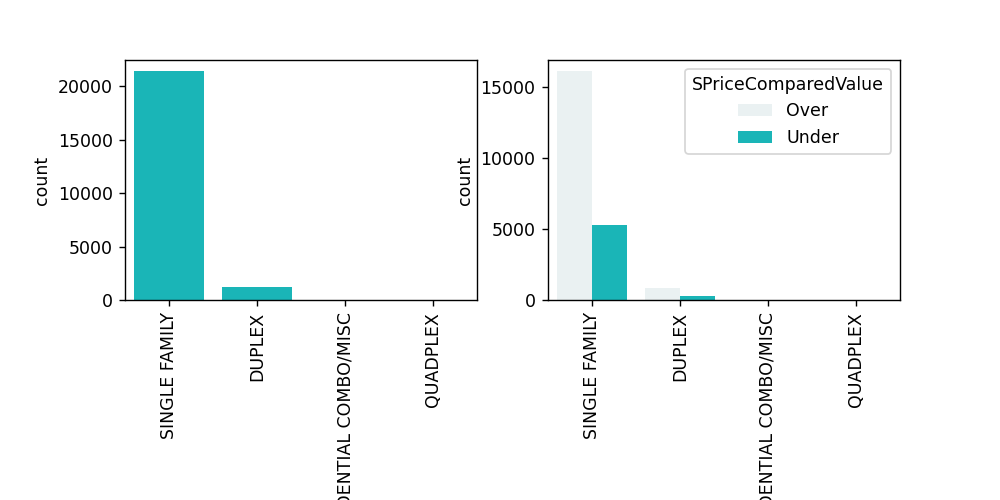

<IPython.core.display.Javascript object>


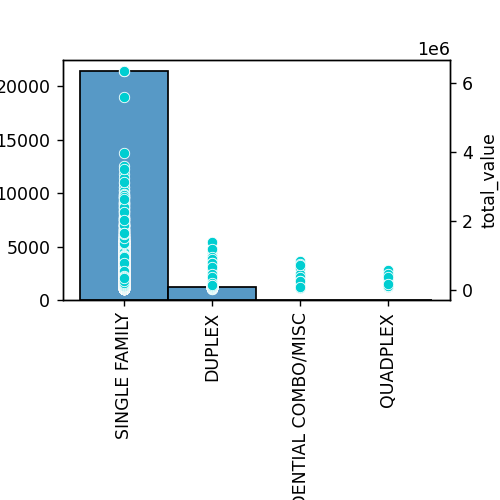



####### Feature : PropertyAddress 

## values in PropertyAddress


C:\Users\singg\AppData\Local\Temp\ipykernel_17160\1789148156.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=list(vc.index), rotation = 90)


2351  HERMAN ST       4
911  WARREN ST        4
1910  LINDEN AVE      4
944  SEYMOUR AVE      4
2208 24TH  AVE N      4
                     ..
3005  DELANEY DR      1
2805  RENEE DR        1
2908  WINDEMERE CT    1
303  BONNALYNN DR     1
1614 5TH  AVE N       1
Name: PropertyAddress, Length: 20448, dtype: int64


## Null Values in PropertyAddress : 2


LandUse PropertyAddress PropertyCity   SaleDate SoldAsVacant  \
17529  SINGLE FAMILY             NaN          NaN   2/4/2016           No   
17696  SINGLE FAMILY             NaN          NaN  2/24/2016           No   

      MParcelsinSale       City  Acreage              TaxDistrict  \
17529             No  NASHVILLE     0.32  URBAN SERVICES DISTRICT   
17696             No  NASHVILLE     0.16  URBAN SERVICES DISTRICT   

       Neighborhood  ...  FinishedArea  FoundationType  YearBuilt  \
17529          3227  ...        4420.0           CRAWL       2016   
17696          3627  ...        2414.0           CRAWL       2016   

      ExteriorWall  Grade Bedrooms FuBath  HaBath  SPriceComparedValue  \
17529  BRICK/FRAME   B         5.0    4.0     1.0                Under   
17696        FRAME   B         4.0    2.0     1.0                Under   

       total_value  
17529       721100  
17696       308100  

[2 rows x 22 columns]


## Converting Address to Street

Before converting : number of Unique addresses  
 20449

After converting : number of Unique addresses 
 3708

After Converting Address 
 THAVEN           524
NTHST            198
STHST            189
THAVES            95
RIVERSIDEDR       78
                ... 
ESTEWARTSLN        1
WALKERCT           1
LYNNCT             1
CYPRESSLEAFCT      1
GOODWINRD          1
Name: PropertyAddress, Length: 3707, dtype: int64


####### Feature : PropertyCity 

## values in PropertyCity


NASHVILLE         18010
MADISON            1146
ANTIOCH            1133
HERMITAGE           913
OLD HICKORY         824
GOODLETTSVILLE      435
BRENTWOOD           158
WHITES CREEK         13
JOELTON              11
MOUNT JULIET          6
Name: PropertyCity, dtype: int64


## Null Values in PropertyCity : 2


LandUse PropertyAddress PropertyCity   SaleDate SoldAsVacant  \
17529  SINGLE FAMILY             NaN          NaN   2/4/2016           No   
17696  SINGLE FAMILY             NaN          NaN  2/24/2016           No   

      MParcelsinSale       City  Acreage              TaxDistrict  \
17529             No  NASHVILLE     0.32  URBAN SERVICES DISTRICT   
17696             No  NASHVILLE     0.16  URBAN SERVICES DISTRICT   

       Neighborhood  ...  FinishedArea  FoundationType  YearBuilt  \
17529          3227  ...        4420.0           CRAWL       2016   
17696          3627  ...        2414.0           CRAWL       2016   

      ExteriorWall  Grade Bedrooms FuBath  HaBath  SPriceComparedValue  \
17529  BRICK/FRAME   B         5.0    4.0     1.0                Under   
17696        FRAME   B         4.0    2.0     1.0                Under   

       total_value  
17529       721100  
17696       308100  

[2 rows x 22 columns]


## Fill PropertyCity with City 

## After fill with the city, Null Values in PropertyCity : 0


####### Feature : SaleDate 

## values in SaleDate


4/29/2016    111
6/30/2016    105
6/28/2013     99
7/31/2015     88
3/31/2016     87
            ... 
2/16/2013      1
4/23/2016      1
11/1/2014      1
6/9/2013       1
8/29/2015      1
Name: SaleDate, Length: 1044, dtype: int64


## Null Values in SaleDate : 0

## converting 'SaleDate' to 'Year', 'Month', 'Day', 'Season', 'Holiday'

## Drop SaleDate


<IPython.core.display.Javascript object>


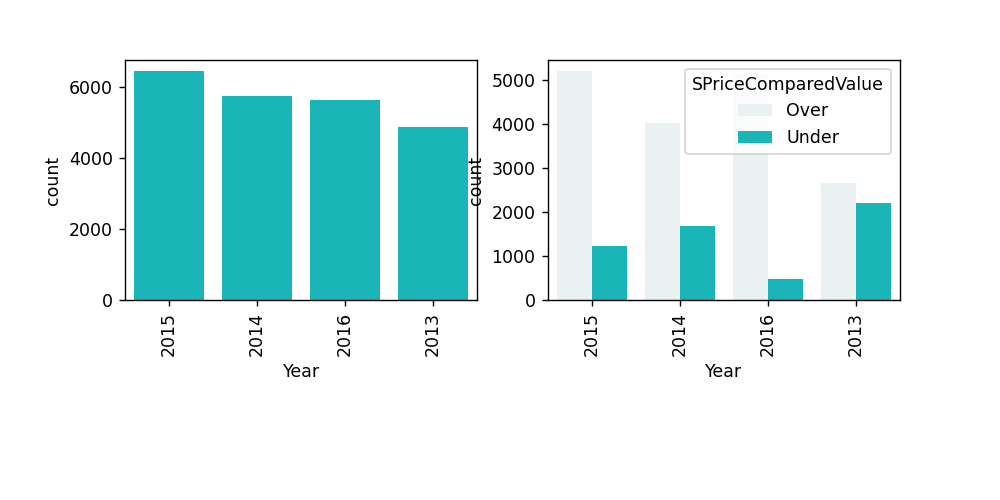

<IPython.core.display.Javascript object>


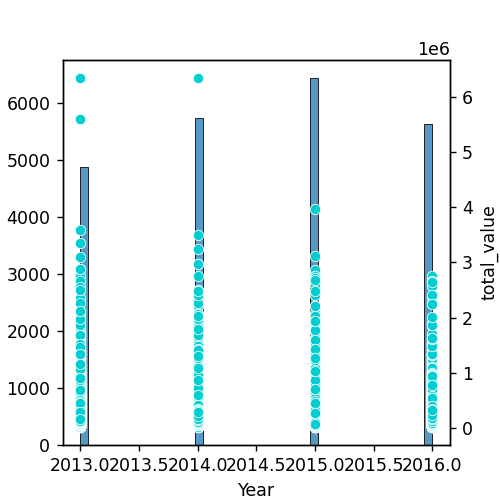

<IPython.core.display.Javascript object>


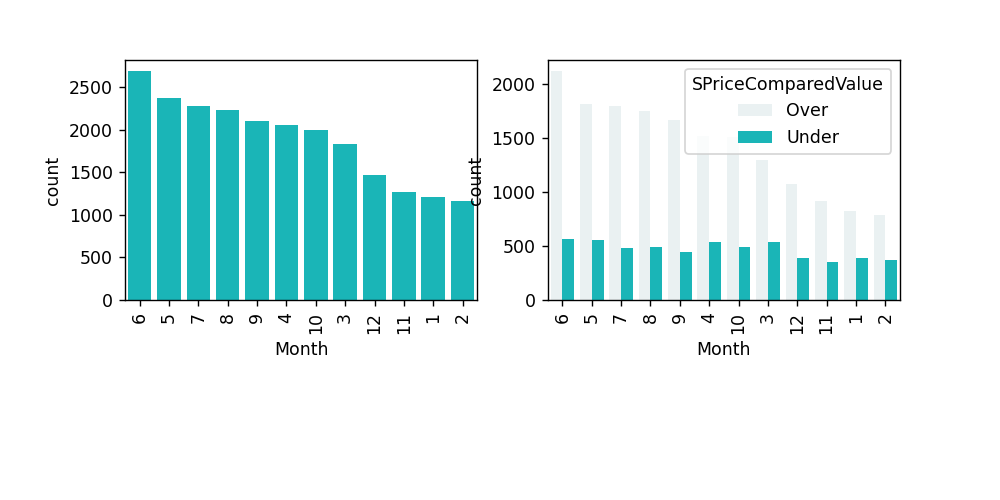

<IPython.core.display.Javascript object>


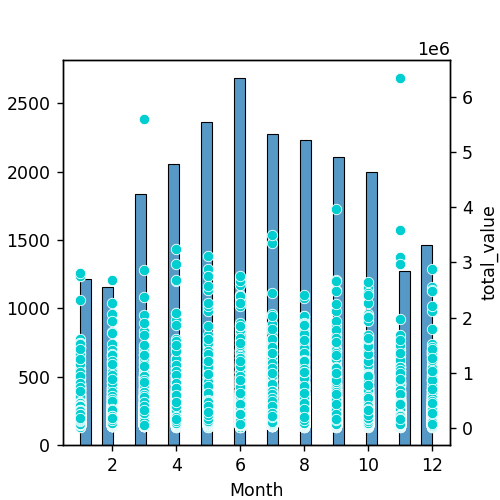

<IPython.core.display.Javascript object>


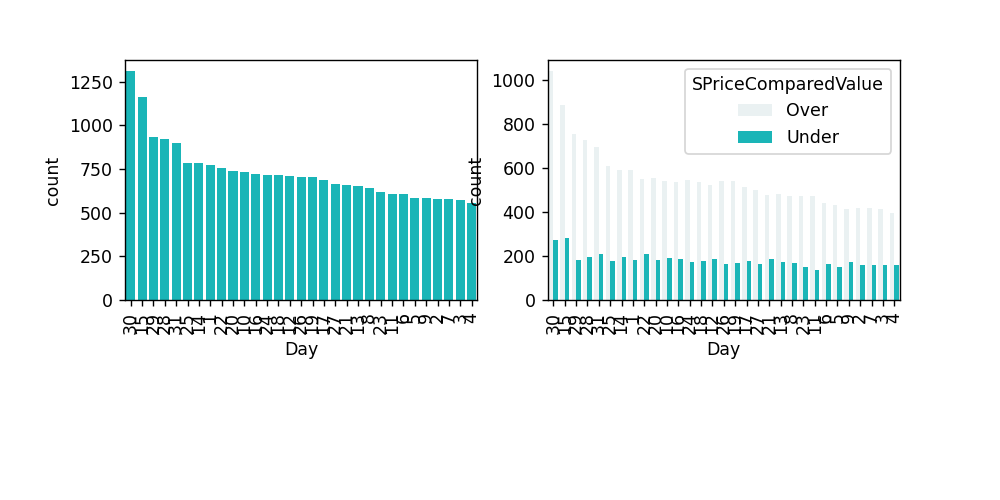

<IPython.core.display.Javascript object>


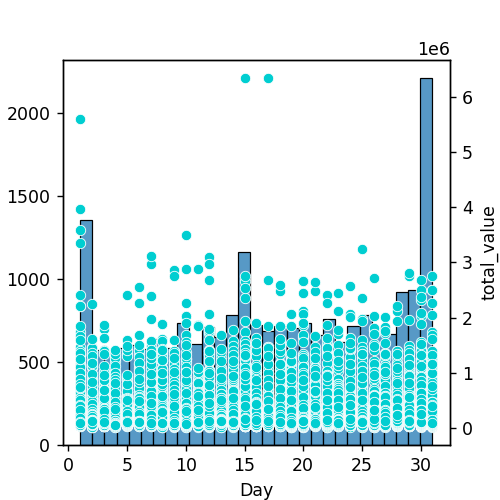

<IPython.core.display.Javascript object>


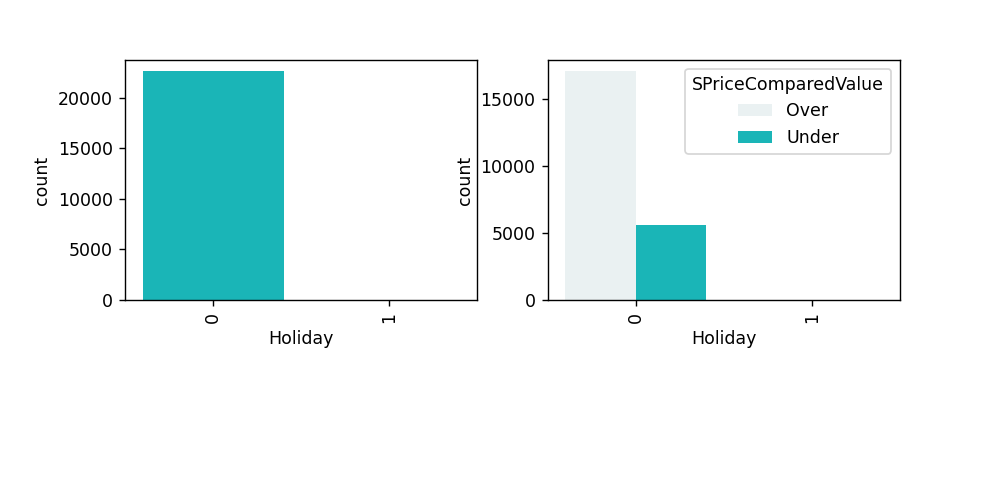

<IPython.core.display.Javascript object>


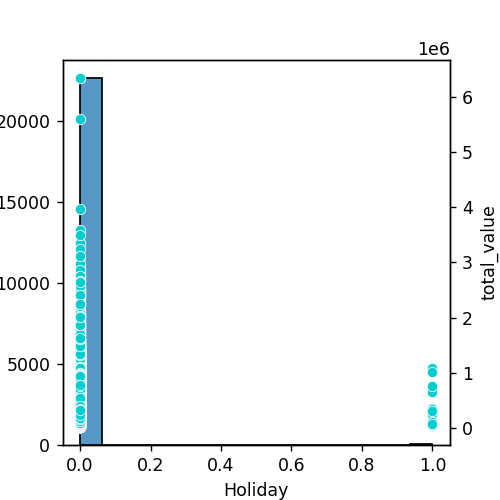

<IPython.core.display.Javascript object>


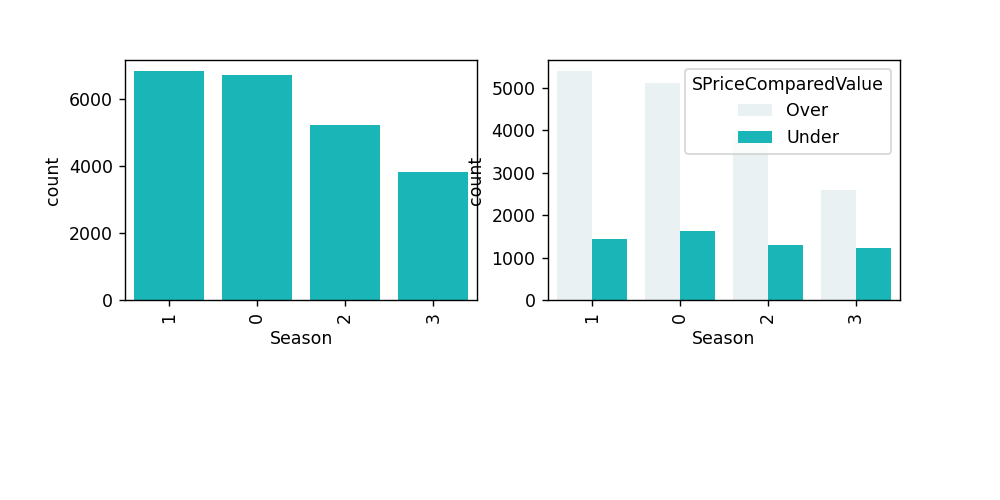

<IPython.core.display.Javascript object>


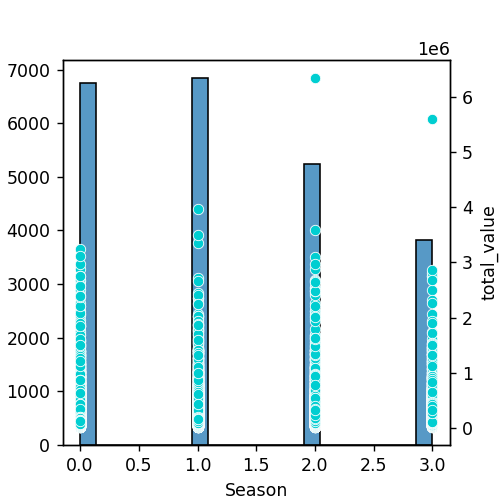



####### Feature : SoldAsVacant 

## values in SoldAsVacant


No     22517
Yes      134
Name: SoldAsVacant, dtype: int64


## Null Values in SoldAsVacant : 0


<IPython.core.display.Javascript object>


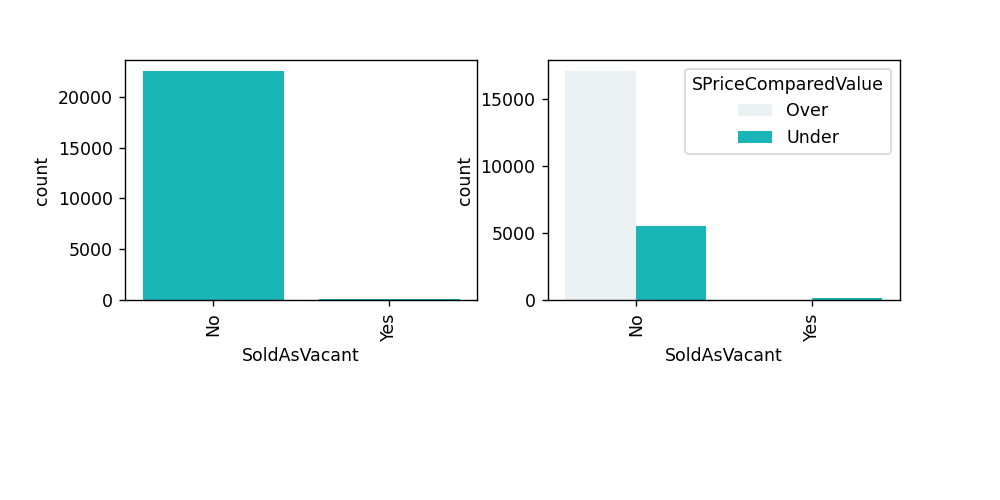

<IPython.core.display.Javascript object>


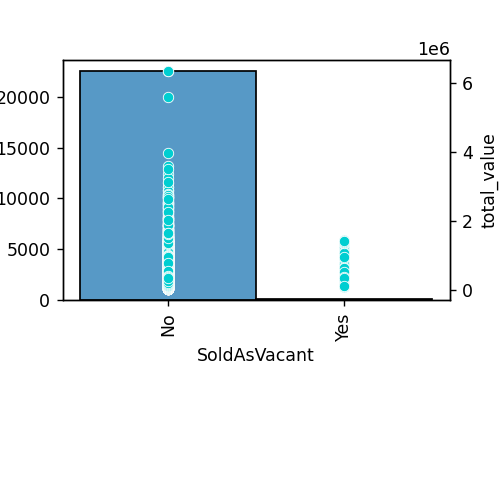



####### Feature : MParcelsinSale 

## values in MParcelsinSale


C:\Users\singg\AppData\Local\Temp\ipykernel_17160\1789148156.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=list(vc.index), rotation = 90)


No     22183
Yes      468
Name: MParcelsinSale, dtype: int64


## Null Values in MParcelsinSale : 0


<IPython.core.display.Javascript object>


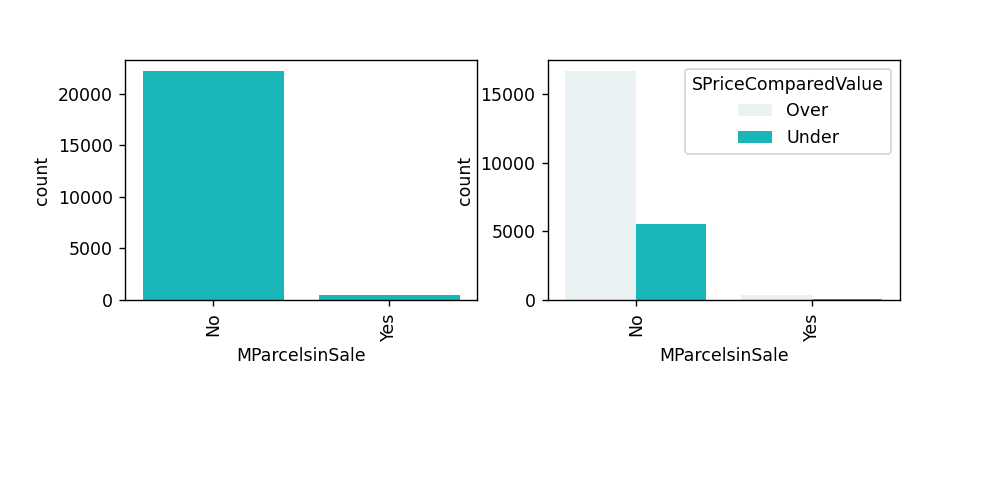

<IPython.core.display.Javascript object>


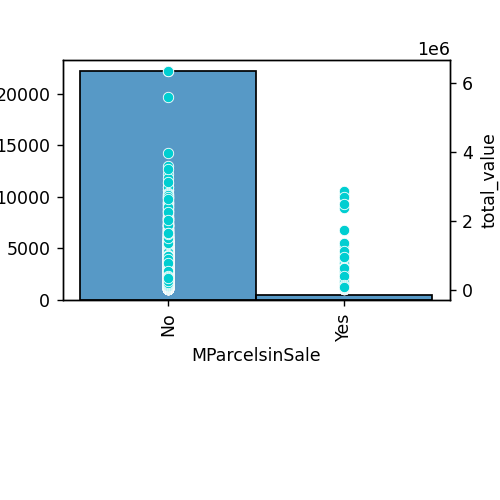



####### Feature : City 

## values in City


C:\Users\singg\AppData\Local\Temp\ipykernel_17160\1789148156.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=list(vc.index), rotation = 90)


NASHVILLE         18013
MADISON            1146
ANTIOCH            1133
HERMITAGE           913
OLD HICKORY         824
GOODLETTSVILLE      435
BRENTWOOD           157
WHITES CREEK         13
JOELTON              11
MOUNT JULIET          6
Name: City, dtype: int64


## Null Values in City : 0


<IPython.core.display.Javascript object>


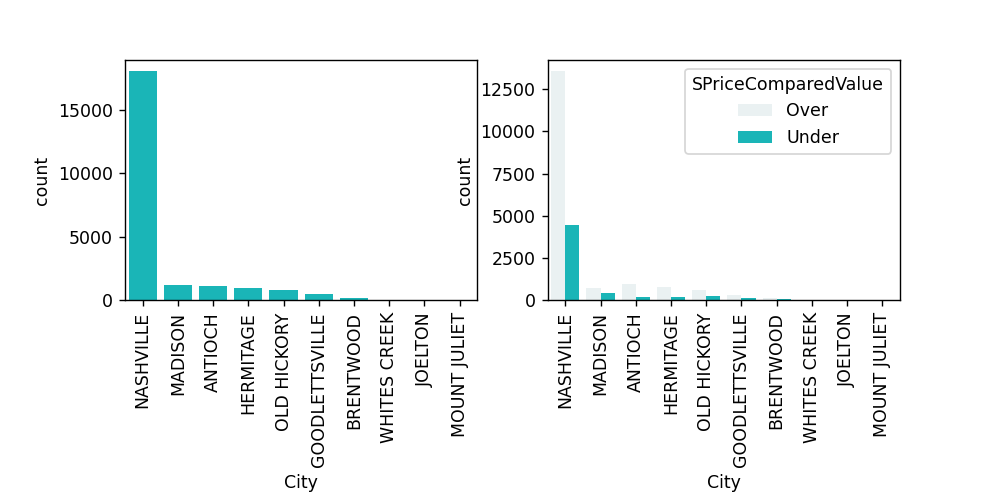

<IPython.core.display.Javascript object>


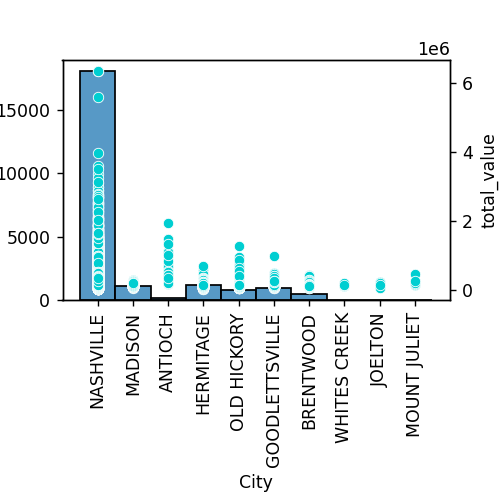



####### Feature : TaxDistrict 

## values in TaxDistrict


C:\Users\singg\AppData\Local\Temp\ipykernel_17160\1789148156.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=list(vc.index), rotation = 90)


URBAN SERVICES DISTRICT      17497
GENERAL SERVICES DISTRICT     3881
CITY OF OAK HILL               349
CITY OF FOREST HILLS           345
CITY OF GOODLETTSVILLE         344
CITY OF BELLE MEADE            214
CITY OF BERRY HILL              21
Name: TaxDistrict, dtype: int64


## Null Values in TaxDistrict : 0


<IPython.core.display.Javascript object>


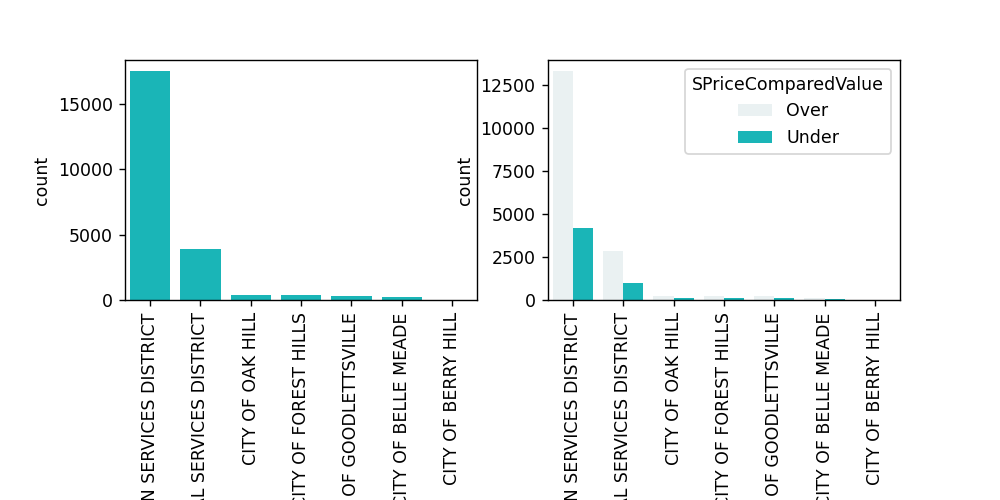

<IPython.core.display.Javascript object>


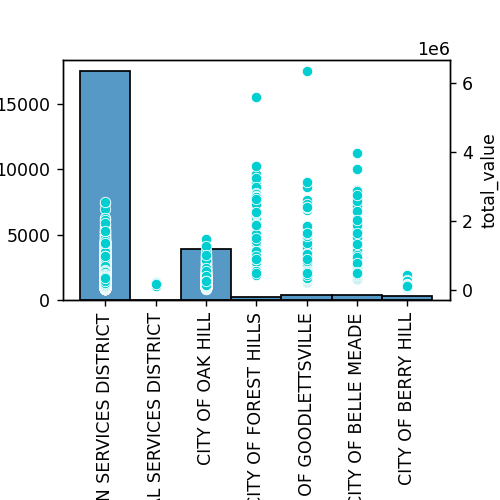

C:\Users\singg\AppData\Local\Temp\ipykernel_17160\1789148156.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=list(vc.index), rotation = 90)




####### Feature : FoundationType 

## values in FoundationType


CRAWL        14210
FULL BSMT     3823
PT BSMT       3146
SLAB          1431
PIERS           36
TYPICAL          4
Name: FoundationType, dtype: int64


## Null Values in FoundationType : 1


C:\Users\singg\AppData\Local\Temp\ipykernel_17160\1789148156.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols =2, figsize = (8,4))


<IPython.core.display.Javascript object>


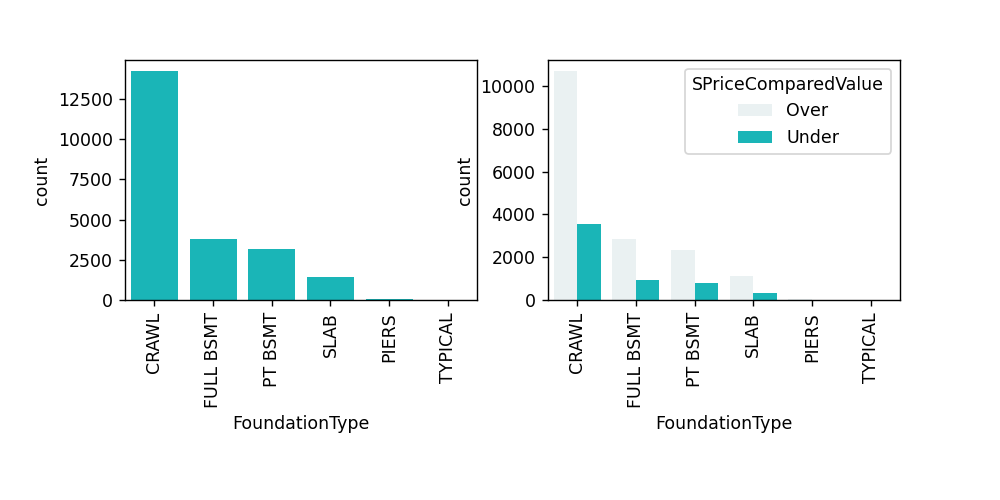

<IPython.core.display.Javascript object>


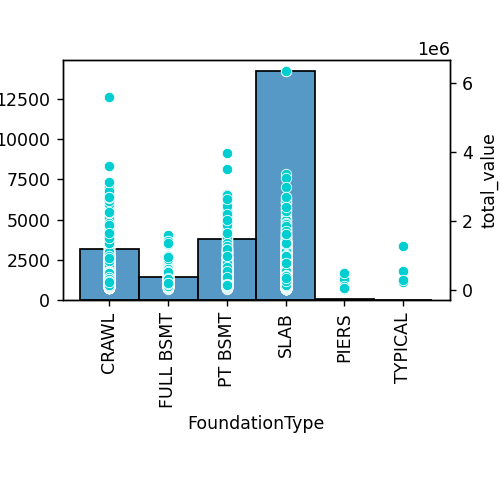

C:\Users\singg\AppData\Local\Temp\ipykernel_17160\1789148156.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=list(vc.index), rotation = 90)




####### Feature : ExteriorWall 

## values in ExteriorWall


BRICK          11547
FRAME           8171
BRICK/FRAME     2222
STONE            329
STUCCO           156
FRAME/STONE      104
CONC BLK          99
LOG               15
METAL              8
Name: ExteriorWall, dtype: int64


## Null Values in ExteriorWall : 0


<IPython.core.display.Javascript object>


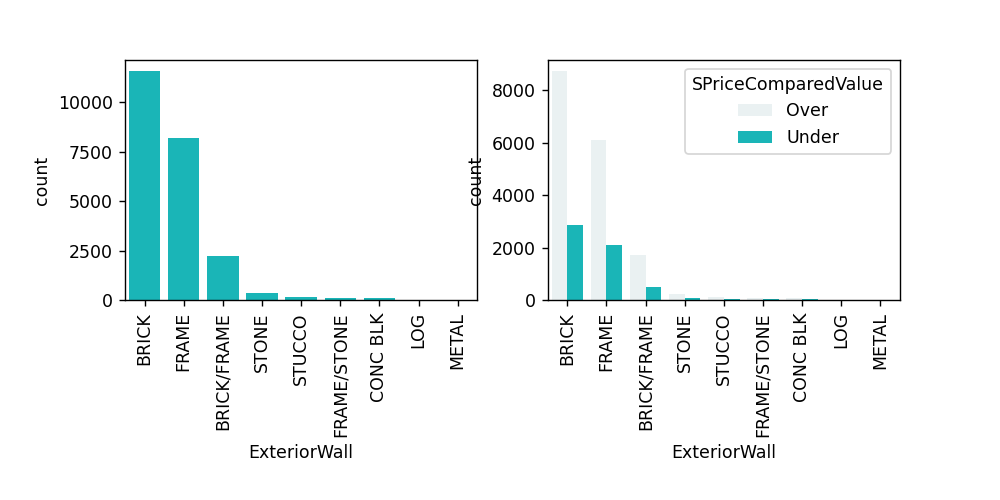

<IPython.core.display.Javascript object>


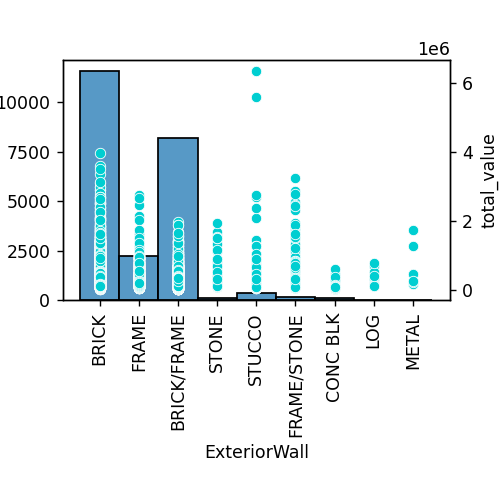



####### Feature : Grade 

## values in Grade


C:\Users\singg\AppData\Local\Temp\ipykernel_17160\1789148156.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=list(vc.index), rotation = 90)


C       16235
B        3395
D        1929
A         549
X         482
E          57
SSC         1
OFC         1
AAB         1
OFB         1
Name: Grade, dtype: int64


## Null Values in Grade : 0


<IPython.core.display.Javascript object>


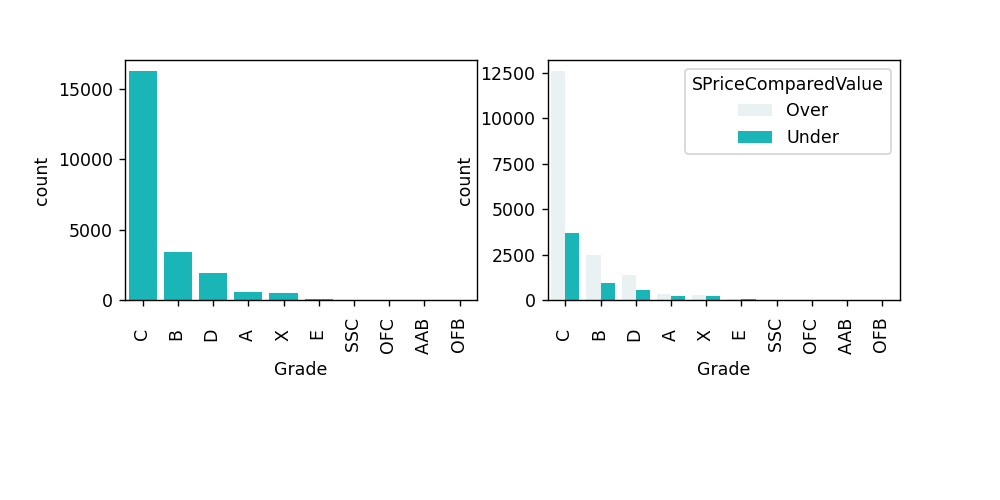

<IPython.core.display.Javascript object>


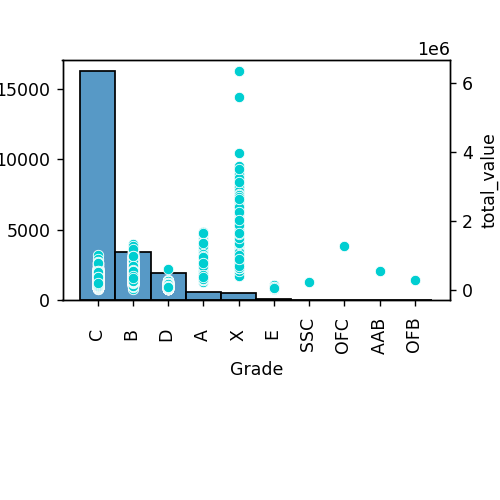



####### Feature : SPriceComparedValue 

## values in SPriceComparedValue


C:\Users\singg\AppData\Local\Temp\ipykernel_17160\1789148156.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=list(vc.index), rotation = 90)


Over     17047
Under     5604
Name: SPriceComparedValue, dtype: int64


## Null Values in SPriceComparedValue : 0


<IPython.core.display.Javascript object>


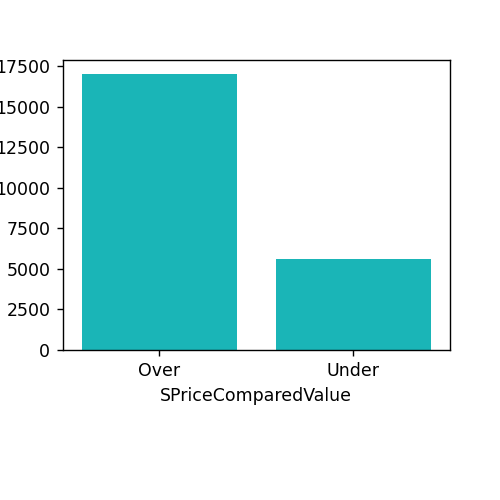

<IPython.core.display.Javascript object>


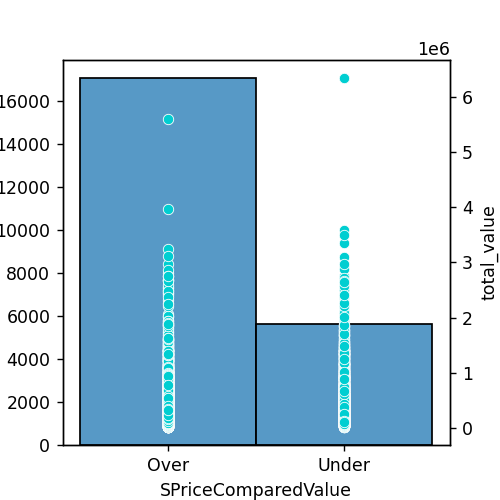



##### Feature : Acreage 
## min of Acreage : 0.04
## max of Acreage : 17.5
## median of Acreage : 0.28
## Null values in Acreage : 0 



<IPython.core.display.Javascript object>


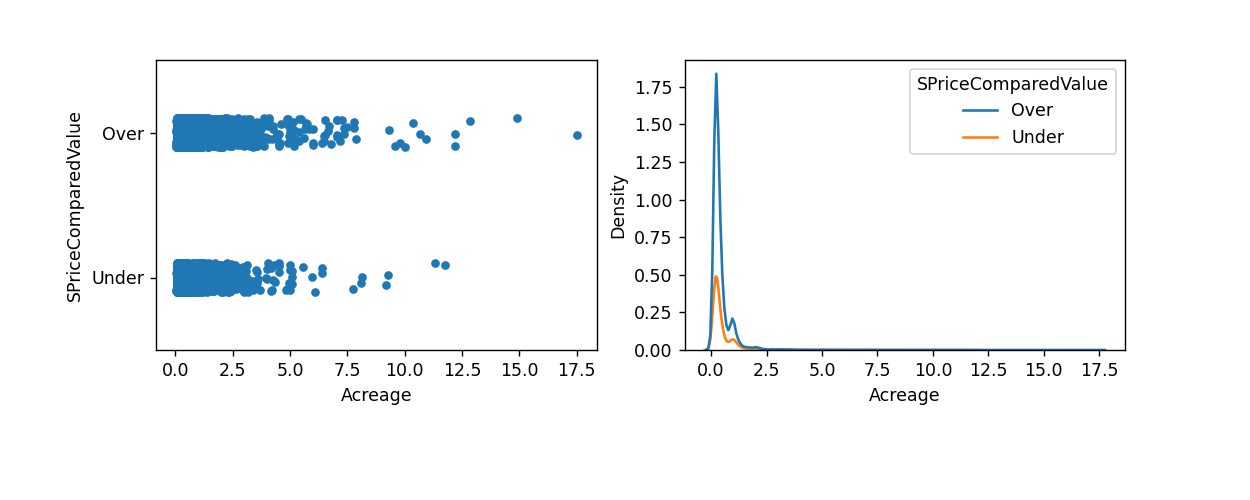



##### Feature : Neighborhood 
## min of Neighborhood : 107
## max of Neighborhood : 9530
## median of Neighborhood : 4026.0
## Null values in Neighborhood : 0 



<IPython.core.display.Javascript object>


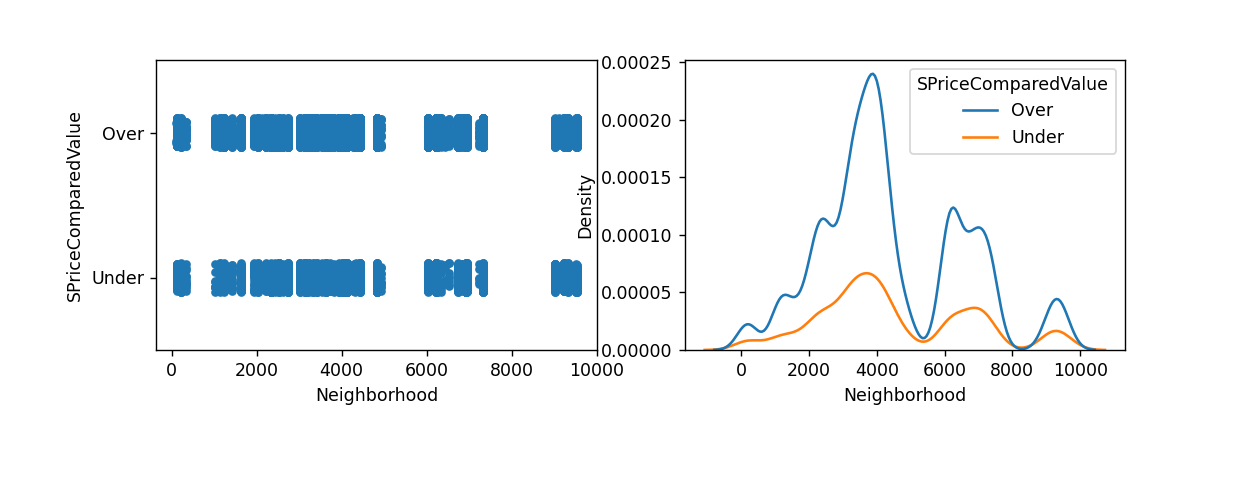



##### Feature : LandValue 
## min of LandValue : 900
## max of LandValue : 1869000
## median of LandValue : 30000.0
## Null values in LandValue : 0 



<IPython.core.display.Javascript object>


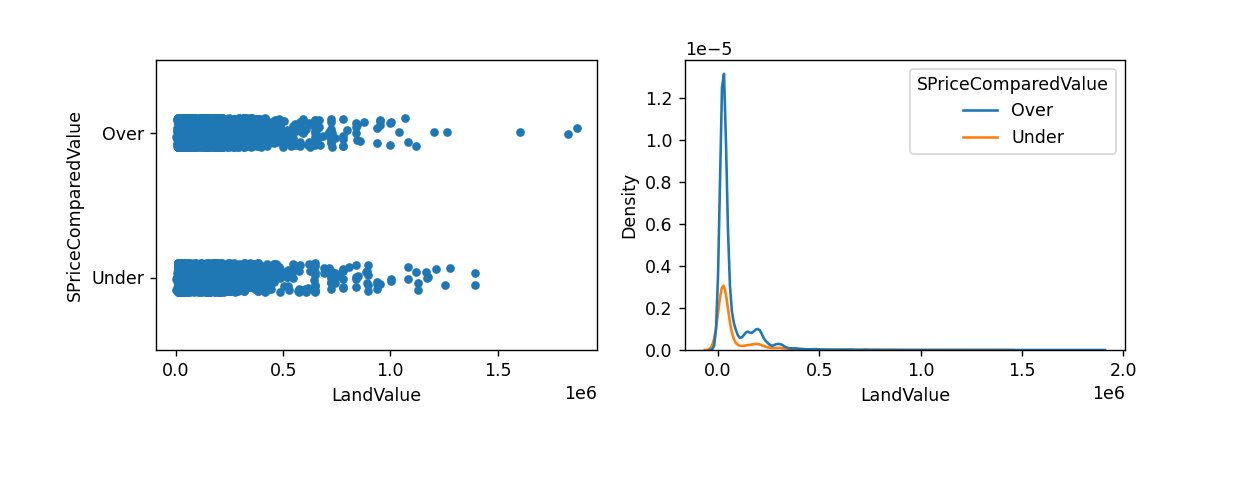



##### Feature : BuildingValue 
## min of BuildingValue : 1400
## max of BuildingValue : 5824300
## median of BuildingValue : 118800.0
## Null values in BuildingValue : 0 



<IPython.core.display.Javascript object>


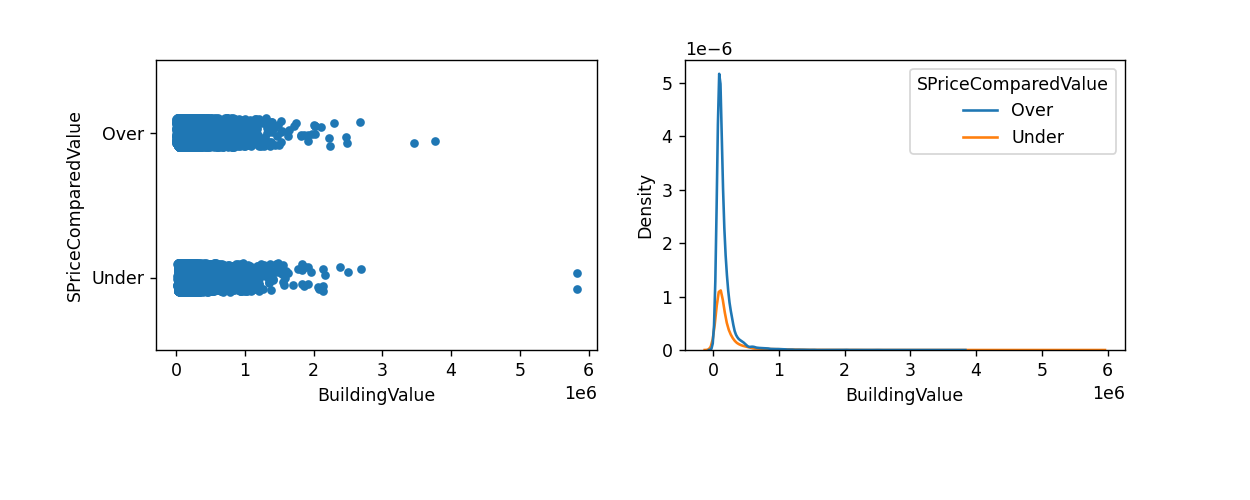



##### Feature : FinishedArea 
## min of FinishedArea : 450.0
## max of FinishedArea : 19728.24988
## median of FinishedArea : 1645.824995
## Null values in FinishedArea : 1 



<IPython.core.display.Javascript object>


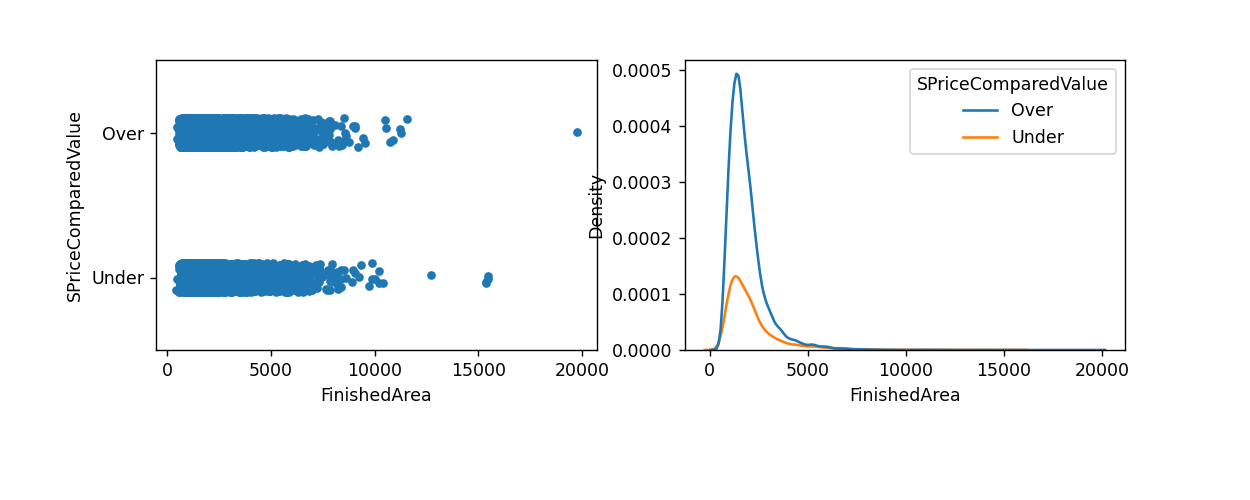



##### Feature : YearBuilt 
## min of YearBuilt : 1832
## max of YearBuilt : 2017
## median of YearBuilt : 1959.0
## Null values in YearBuilt : 0 



<IPython.core.display.Javascript object>


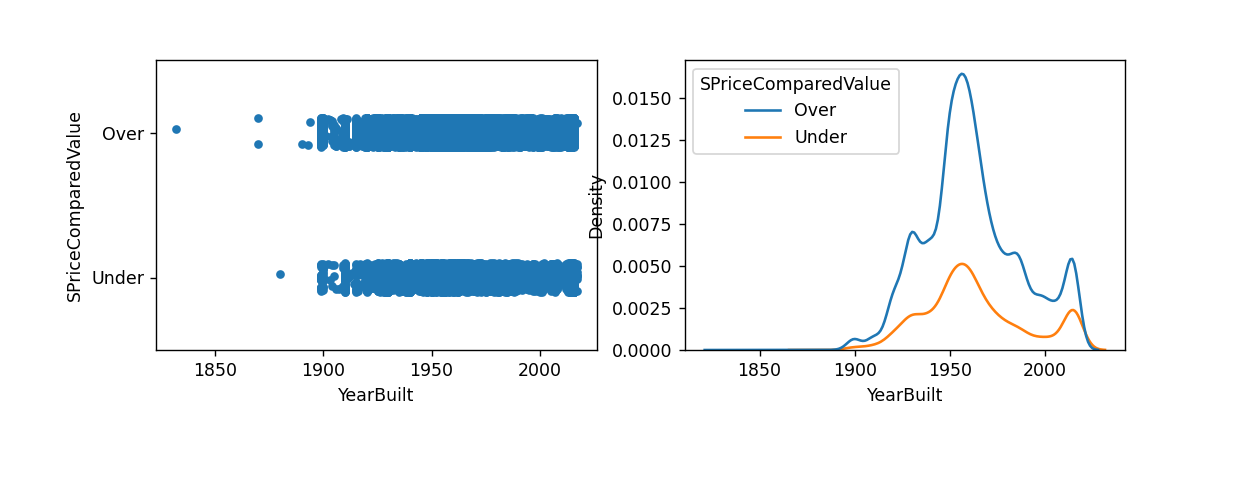



##### Feature : Bedrooms 
## min of Bedrooms : 0.0
## max of Bedrooms : 11.0
## median of Bedrooms : 3.0
## Null values in Bedrooms : 3 

Values in Bedrooms : 
 3.0     12273
4.0      4646
2.0      4577
5.0       820
6.0       194
1.0        79
7.0        29
8.0        21
0.0         4
10.0        2
9.0         2
11.0        1
Name: Bedrooms, dtype: int64


<IPython.core.display.Javascript object>


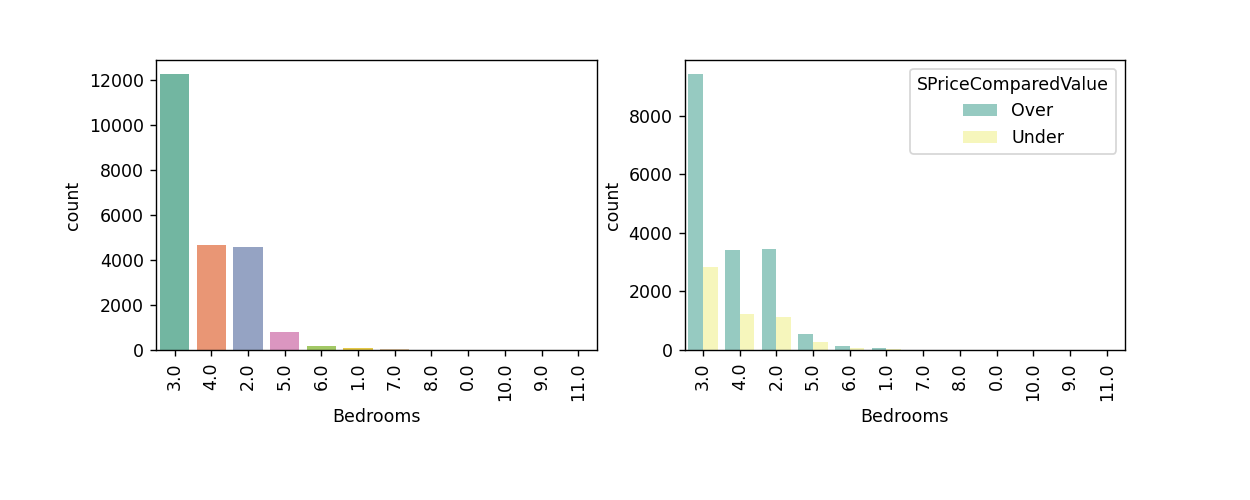



##### Feature : FuBath 
## min of FuBath : 0.0
## max of FuBath : 10.0
## median of FuBath : 2.0
## Null values in FuBath : 1 

Values in FuBath : 
 2.0     9263
1.0     8906
3.0     3137
4.0      921
5.0      304
6.0       80
7.0       15
0.0       11
8.0        6
10.0       4
9.0        3
Name: FuBath, dtype: int64


<IPython.core.display.Javascript object>


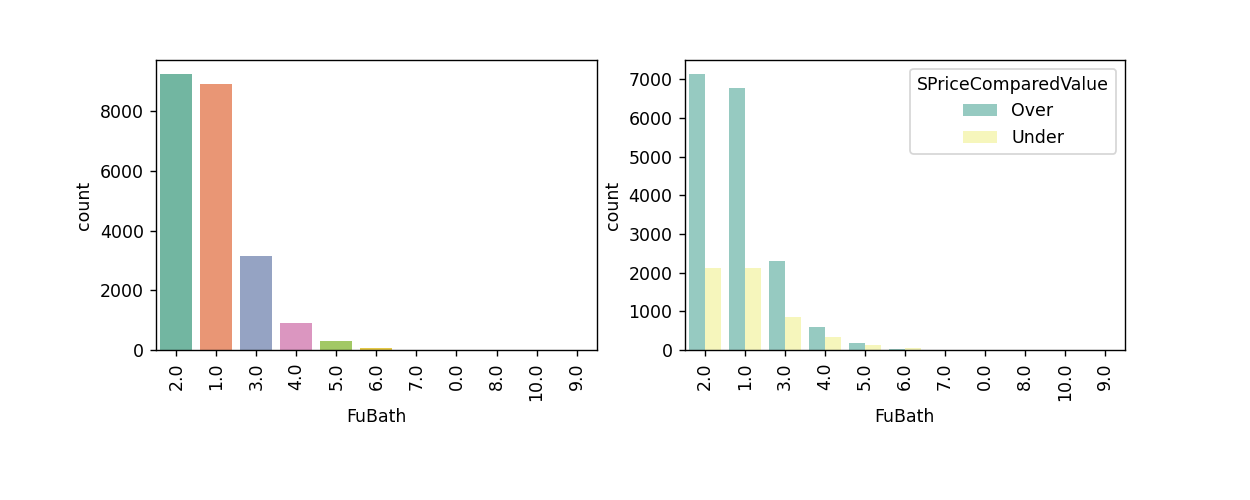



##### Feature : HaBath 
## min of HaBath : 0.0
## max of HaBath : 3.0
## median of HaBath : 0.0
## Null values in HaBath : 108 

Values in HaBath : 
 0.0    16804
1.0     5409
2.0      307
3.0       23
Name: HaBath, dtype: int64


<IPython.core.display.Javascript object>


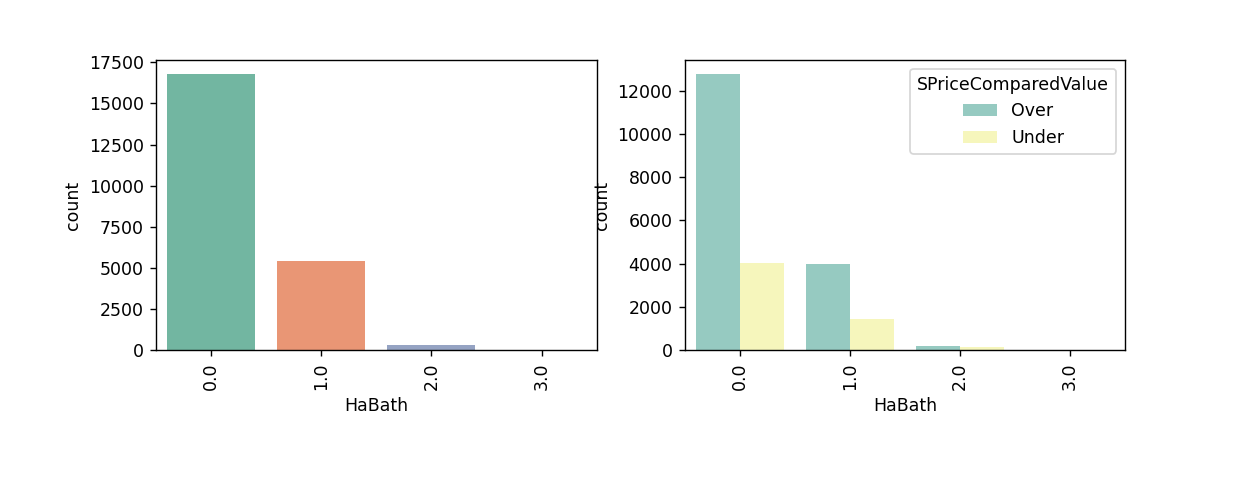



##### Feature : Year 
## min of Year : 2013
## max of Year : 2016
## median of Year : 2015.0
## Null values in Year : 0 

Values in Year : 
 2015    6429
2014    5728
2016    5621
2013    4873
Name: Year, dtype: int64


<IPython.core.display.Javascript object>


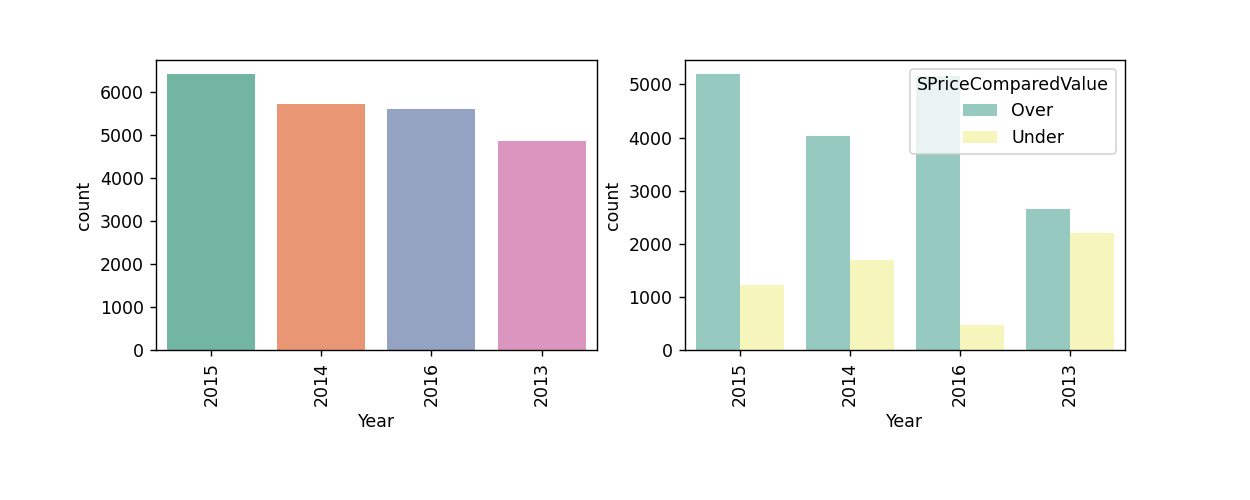



##### Feature : Month 
## min of Month : 1
## max of Month : 12
## median of Month : 7.0
## Null values in Month : 0 

Values in Month : 
 6     2682
5     2366
7     2272
8     2232
9     2105
4     2058
10    1999
3     1833
12    1466
11    1270
1     1212
2     1156
Name: Month, dtype: int64


<IPython.core.display.Javascript object>


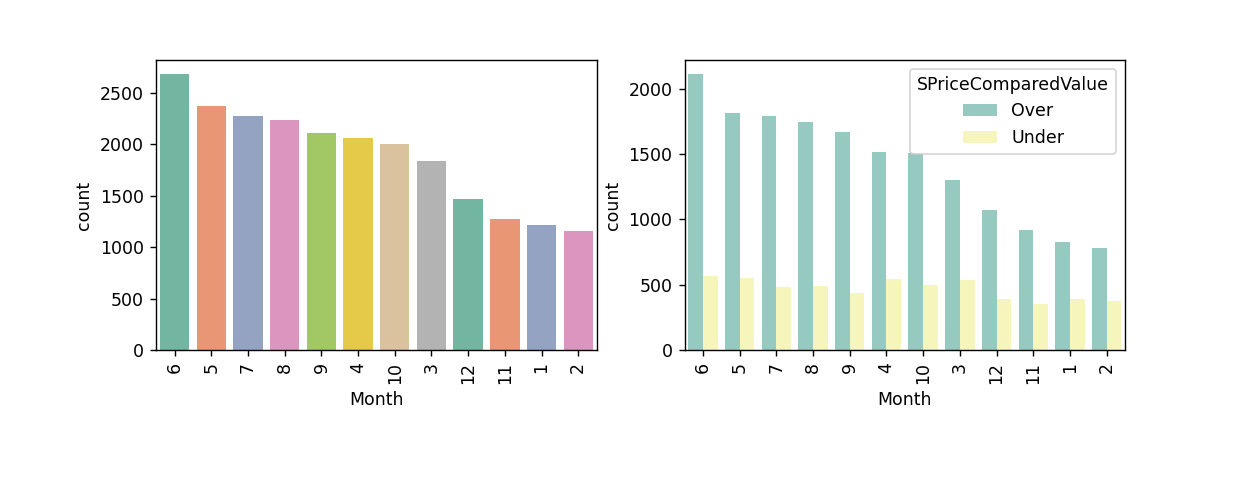



##### Feature : Day 
## min of Day : 1
## max of Day : 31
## median of Day : 17.0
## Null values in Day : 0 

Values in Day : 
 30    1309
15    1164
29     931
28     921
31     899
25     784
14     783
1      775
22     757
20     737
10     733
16     720
24     718
18     714
12     712
26     705
19     705
17     689
27     666
21     661
13     652
8      641
23     619
11     608
6      605
5      583
9      582
2      578
7      576
3      570
4      554
Name: Day, dtype: int64


<IPython.core.display.Javascript object>


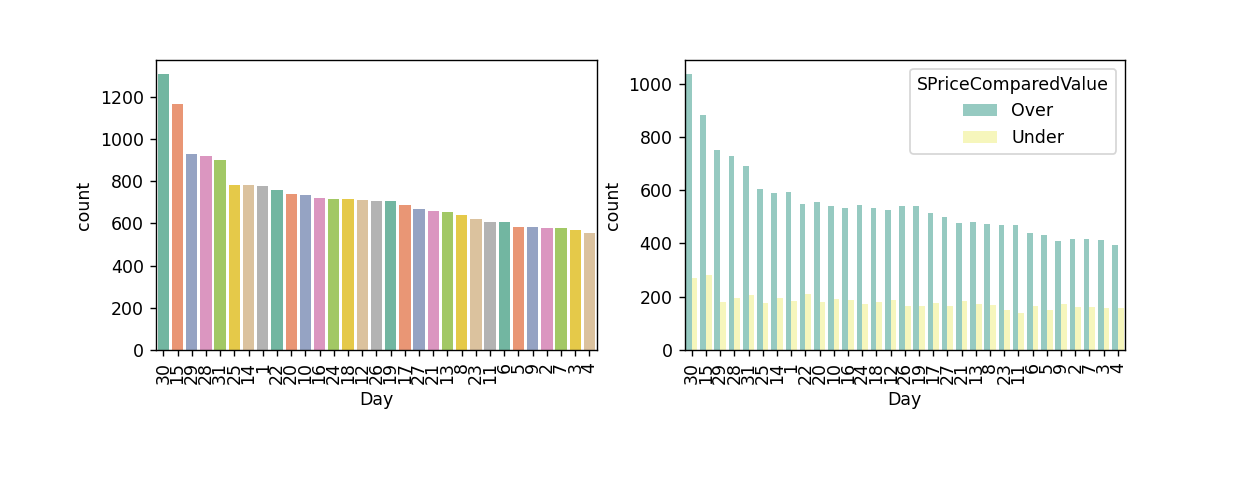



##### Feature : Holiday 
## min of Holiday : 0
## max of Holiday : 1
## median of Holiday : 0.0
## Null values in Holiday : 0 

Values in Holiday : 
 0    22609
1       42
Name: Holiday, dtype: int64


<IPython.core.display.Javascript object>


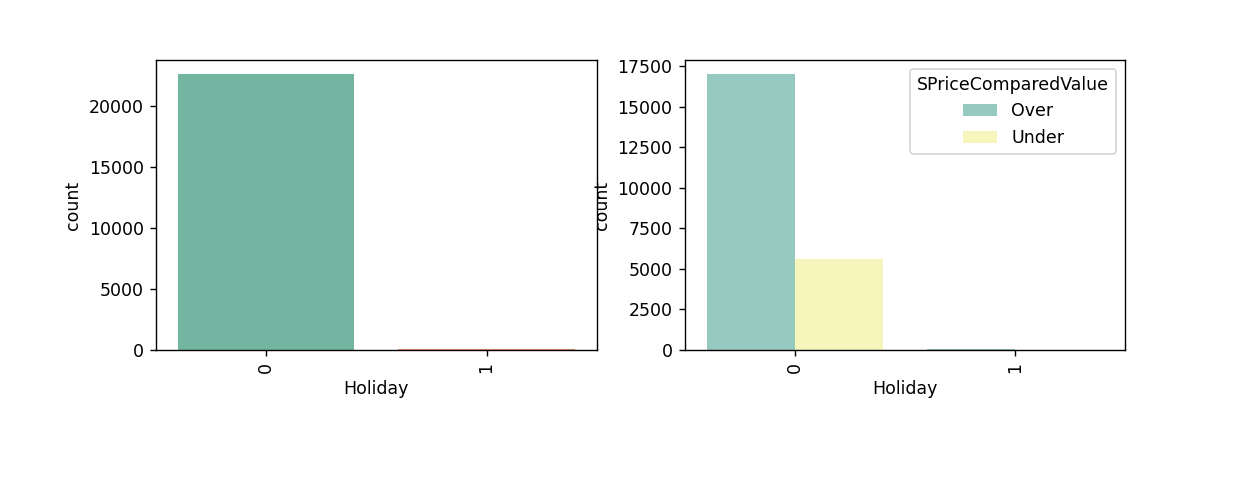



##### Feature : Season 
## min of Season : 0
## max of Season : 3
## median of Season : 1.0
## Null values in Season : 0 

Values in Season : 
 1    6837
0    6741
2    5246
3    3827
Name: Season, dtype: int64


<IPython.core.display.Javascript object>


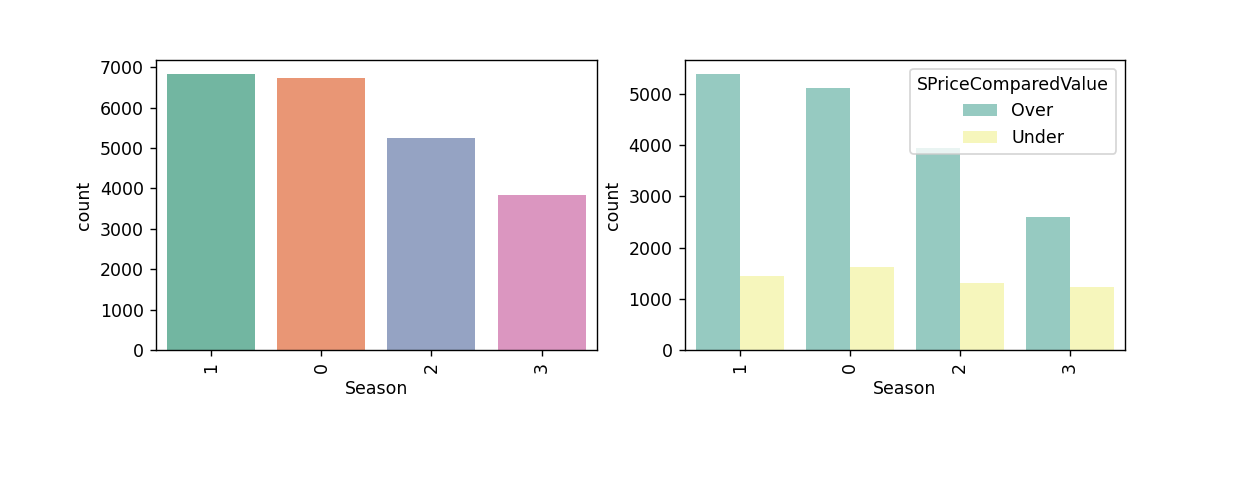


#### Labels for encoding 



DUPLEX  QUADPLEX  RESIDENTIAL COMBO/MISC  SINGLE FAMILY
LandUse       0         1                       2              3

AABBOTTMARTINRD  AALAMEDAST  AALHAMBRACIR  AALLENRD  \
PropertyAddress                0           1             2         3   

                 AASHWOODAVE  AAUBURNLN  ABAXTERAVE  ABBAYDR  ABBOTTCT  \
PropertyAddress            4          5           6        7         8   

                 ABBOTTDR  ABBOTTMARTINRD  ABEECHWOODAVE  ABELVIDEREDR  \
PropertyAddress         9              10             11            12   

                 ABENALLENRD  ABENITADR  
PropertyAddress           13         14

ABERDEENRD  ABERWICKTRL  ABLAIRBLVD  ABONNACROFTDR  \
PropertyAddress          15           16          17             18   

                 ABOSCOBELST  ABRADFORDAVE  ABREWERCT  ABRIARWOODDR  \
PropertyAddress           19            20         21            22   

                 ABRICKCHURCHPIKE  ABROOKSAVE  ABURRUSST  ACABINHILLRD  \
PropertyAddress                23          24         25            26   

                 ACAHALAVE  ACALDWELLLN  ACALIFORNIAAVE  ACASTLEMANDR  
PropertyAddress         27           28              29            30

ACEDARCRESTAVE  ACHESTERAVE  ACHIEVEMENTDR  ACKERMANCT  \
PropertyAddress              31           32             33          34   

                 ACKLENAVE  ACKLENPARKDR  ACLARKEST  ACLAYTONAVE  \
PropertyAddress         35            36         37           38   

                 ACOLORADOAVE  ACREIGHTONAVE  ...  XAVIERDR  YANCEYDR  \
PropertyAddress            39             40  ...      3698      3699   

                 YELTONDR  YOESTCIR  YOESTDR  YORKTOWNRD  YOUNGSLN  YOWELLAVE  \
PropertyAddress      3700      3701     3702        3703      3704       3705   

                 ZOPHIST   NaN  
PropertyAddress     3706  3707  

[1 rows x 3677 columns]

ANTIOCH  BRENTWOOD  GOODLETTSVILLE  HERMITAGE  JOELTON  MADISON  \
PropertyCity        0          1               2          3        4        5   

              MOUNT JULIET  NASHVILLE  OLD HICKORY  WHITES CREEK  
PropertyCity             6          7            8             9

No  Yes
SoldAsVacant   0    1

No  Yes
MParcelsinSale   0    1

ANTIOCH  BRENTWOOD  GOODLETTSVILLE  HERMITAGE  JOELTON  MADISON  \
City        0          1               2          3        4        5   

      MOUNT JULIET  NASHVILLE  OLD HICKORY  WHITES CREEK  
City             6          7            8             9

CITY OF BELLE MEADE  CITY OF BERRY HILL  CITY OF FOREST HILLS  \
TaxDistrict                    0                   1                     2   

             CITY OF GOODLETTSVILLE  CITY OF OAK HILL  \
TaxDistrict                       3                 4   

             GENERAL SERVICES DISTRICT  URBAN SERVICES DISTRICT  
TaxDistrict                          5                        6

CRAWL  FULL BSMT  PIERS  PT BSMT  SLAB  TYPICAL  NaN
FoundationType      0          1      2        3     4        5    6

BRICK  BRICK/FRAME  CONC BLK  FRAME  FRAME/STONE  LOG  METAL  \
ExteriorWall      0            1         2      3            4    5      6   

              STONE  STUCCO  
ExteriorWall      7       8

A     AAB   B     C     D     E     OFB   OFC   SSC   X   
Grade     0     1     2     3     4     5     6     7     8     9

Over  Under
SPriceComparedValue     0      1





 Dataset with high significant variables
         Current function value: 0.493889
         Iterations: 35
                            Logit Regression Results                           
Dep. Variable:     SPriceComparedValue   No. Observations:                18120
Model:                           Logit   Df Residuals:                    18095
Method:                            MLE   Df Model:                           24
Date:                 Sun, 04 Dec 2022   Pseudo R-squ.:                  0.1169
Time:                         14:01:28   Log-Likelihood:                -8949.3
converged:                       False   LL-Null:                       -10134.
Covariance Type:             nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1471.5755     37.312     39.440      0.000    1398.445    1544.7

C:\Users\singg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<IPython.core.display.Javascript object>


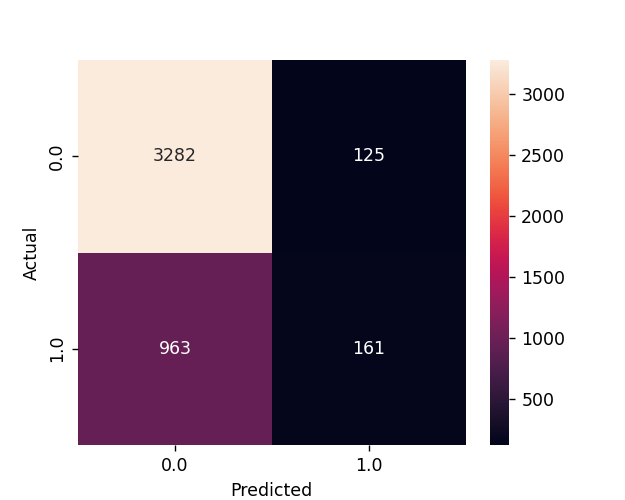

MSE :  0.24012359302582212
accuracy 0.7598764069741779
precision 0.5629370629370629
recall 0.14323843416370108
start 1670180488.4878626
end 1670180488.4878626
Time :  0.0 seconds


<IPython.core.display.Javascript object>


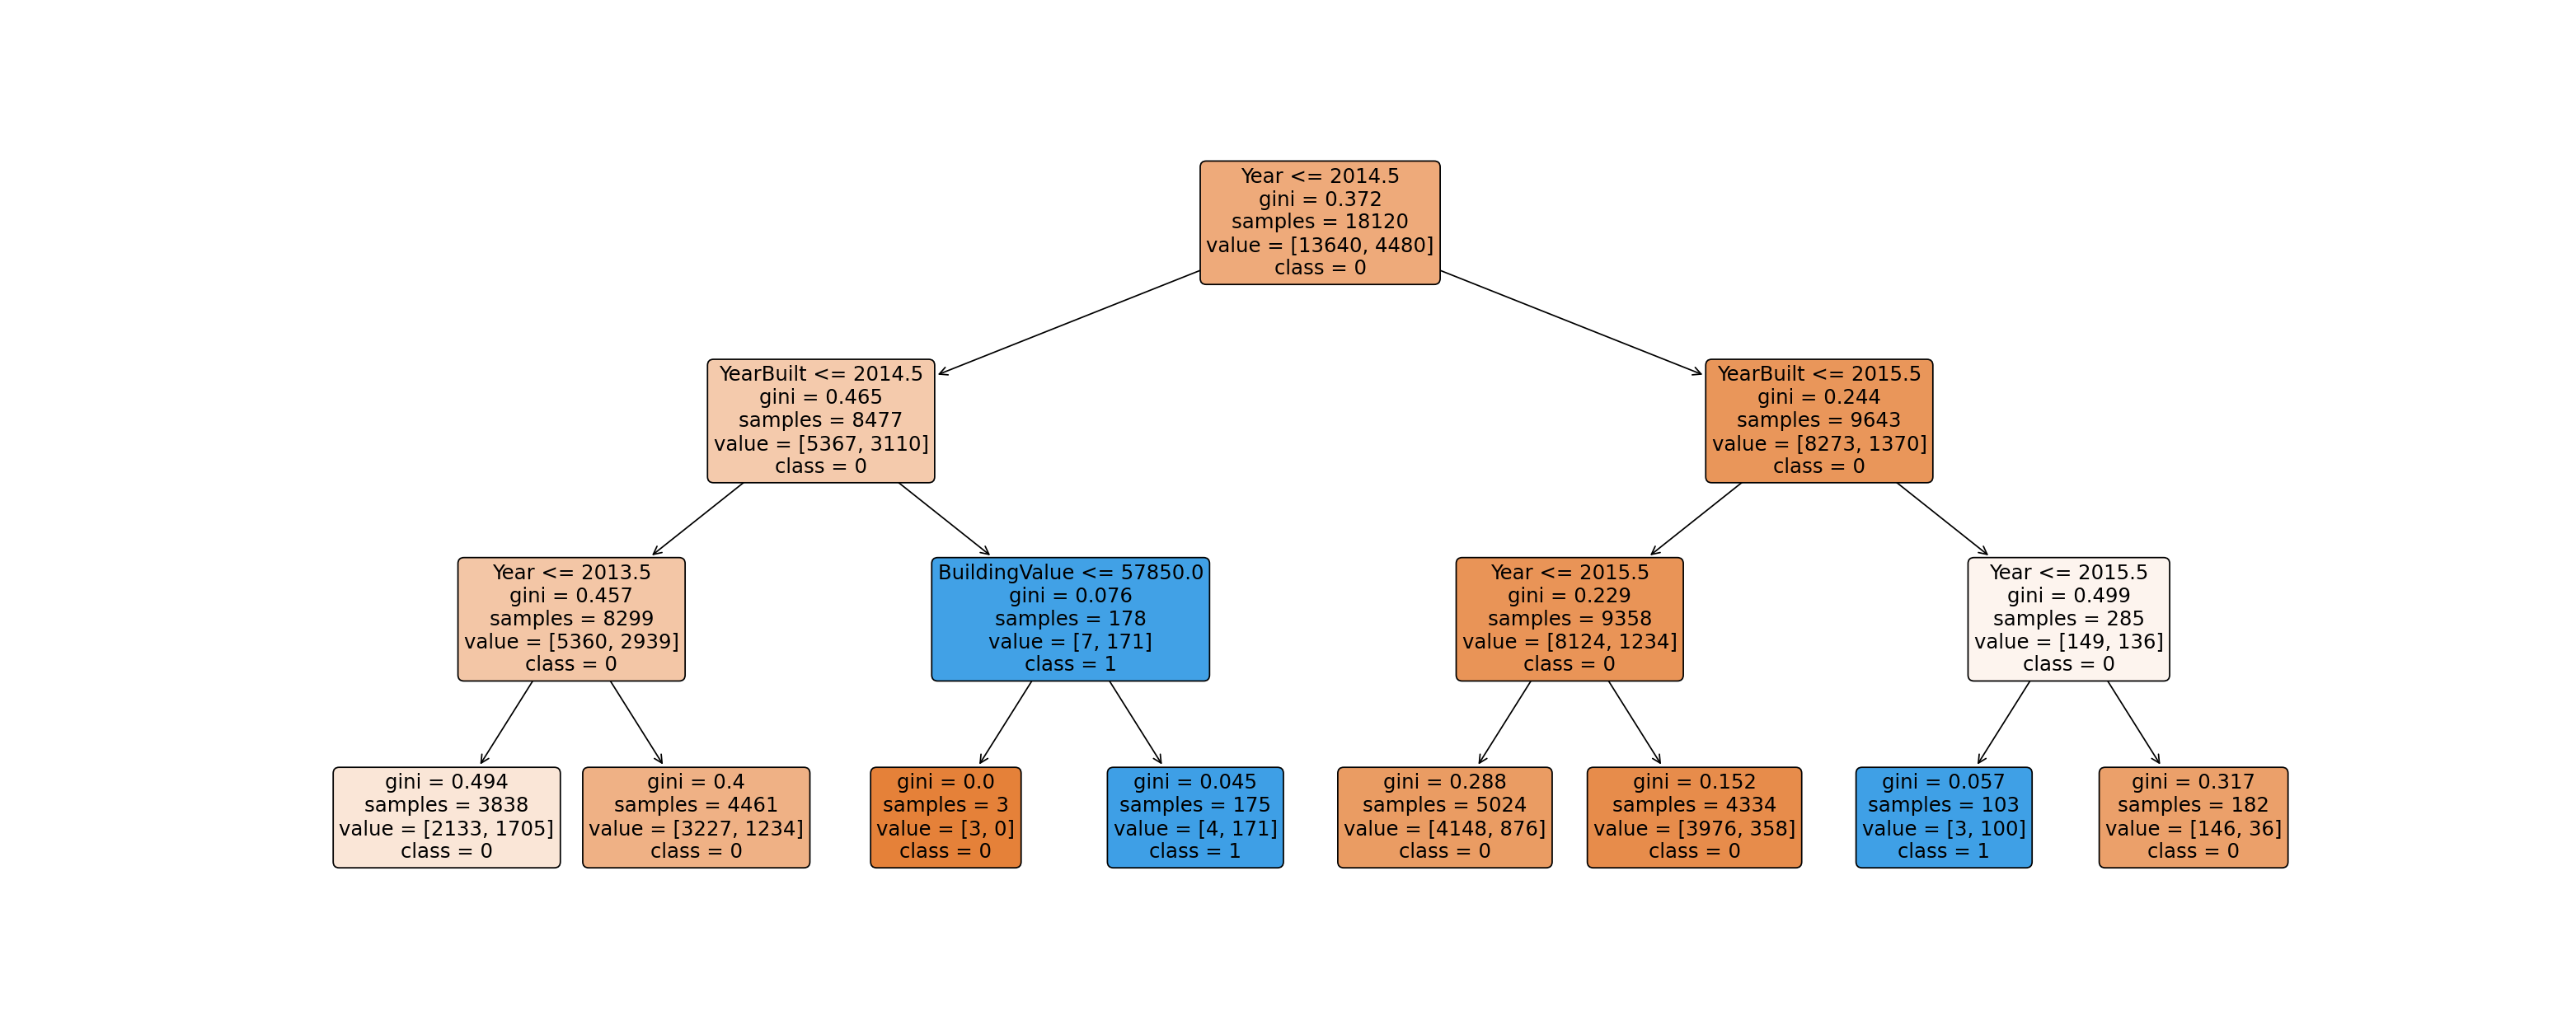


#########Benchmarking


###Decision Tree

Accuracy :  0.7684837784153609
MSE :  0.23151622158463916
Recall :  0.0694
Precision :  0.963
start 1670180493.1194432
end 1670180493.1205795
Time :  0.00114 seconds
Confusion Matrix : 
 [[3404    3]
 [1046   78]]


<IPython.core.display.Javascript object>


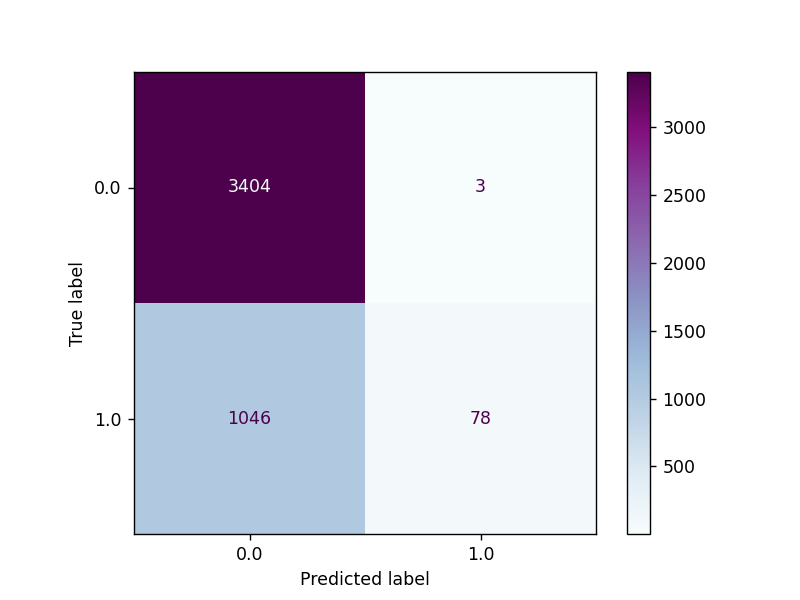


###Random Forest

Accuracy :  0.785919223129552
MSE :  0.21408077687044802
Recall :  0.2794
Precision :  0.6624
start 1670180493.1742508
end 1670180493.1913111
Time :  0.01706 seconds
Confusion Matrix : 
 [[3247  160]
 [ 810  314]]


<IPython.core.display.Javascript object>


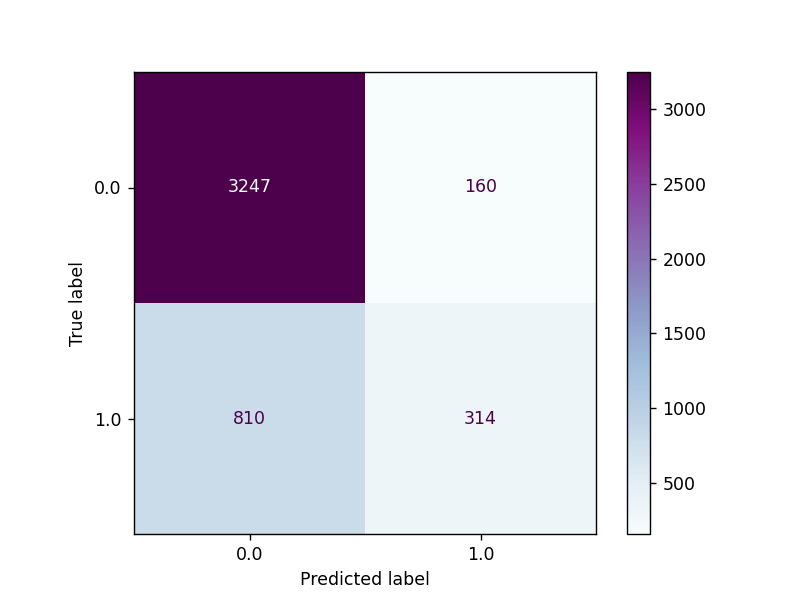


###XGBoost

Accuracy :  0.7848157139704259
MSE :  0.21518428602957404
Confusion Matrix : 
 [[3285  122]
 [ 853  271]]
Recall :  0.2411
Precision :  0.6896
start 1670180493.2378976
end 1670180493.244443
Time :  0.00655 seconds


<IPython.core.display.Javascript object>


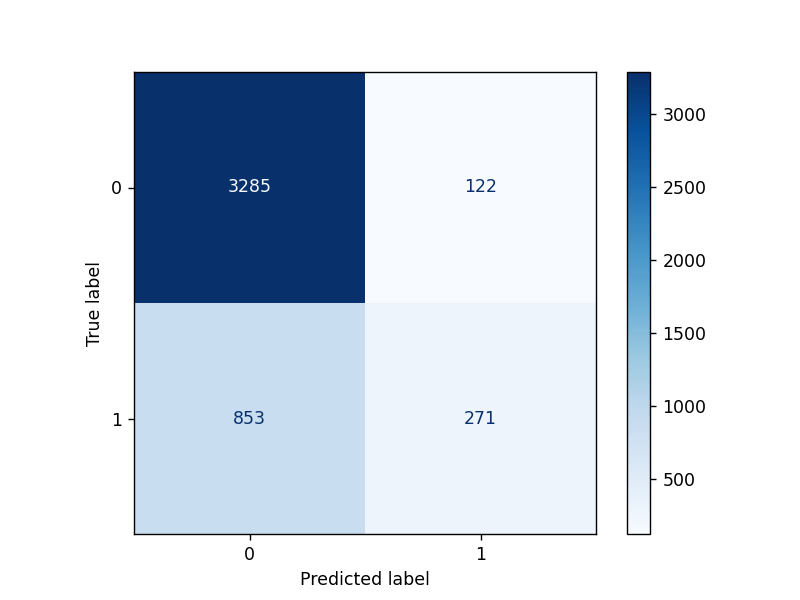

In [25]:
if __name__ == "__main__":
    ##### load Data
    df = pd.read_csv("week 4 - Nashville_housing_data.csv").iloc[:,1:]
    
    ##### check initial dataset
    df = init_df(df)
    
    ##### check and convert variables       
    df['total_value'] = df['LandValue']+df['BuildingValue']
    catv_list = ['LandUse','PropertyAddress','PropertyCity','SaleDate',\
             'SoldAsVacant','MParcelsinSale','City','TaxDistrict',\
             'FoundationType','ExteriorWall','Grade','SPriceComparedValue']
    exp_catvar(df, catv_list)
    contv_list = ['Acreage', 'Neighborhood','LandValue','BuildingValue',\
              'FinishedArea','YearBuilt','Bedrooms','FuBath','HaBath',\
             'Year','Month','Day','Holiday','Season']
    exp_contvar(df, contv_list)
    
    ##### imputation
    df = knn_imput(df)    
    
    ##### Backword Selection
    #X_train, X_test, y_train, y_test = split_dataset(df)
    #m_log = m_Log(X_train, y_train)
    
    #d_list = ['City', 'Holiday','Grade','PropertyAddress','ExteriorWall','HaBath', 'Bedrooms',\
              #'FuBath','Neighborhood','YearBuilt','FinishedArea','FoundationType','LandUse']
    #backward_sel(d_list)
    
    ##### Dataset with selected variables
    print("\n\n Dataset with high significant variables")
    d_list = ['City', 'Holiday','Grade','PropertyAddress','ExteriorWall','HaBath', 'Bedrooms',\
          'FuBath','Neighborhood','YearBuilt','FinishedArea','FoundationType', 'LandUse']
    n_df = df.drop(d_list, axis=1)
    var_l = list(n_df.columns)
    
    ##### Check details of sig_variables
    #print("\n\n Check significance of variables ")
    #oneh_encoded = pd.get_dummies(data=n_df, columns = ['PropertyCity', 'TaxDistrict','Season'] )
    #X_train, X_test, y_train, y_test = split_dataset(oneh_encoded)
    #var_l = list(oneh_encoded.columns)
    #n_m_log = m_Log(X_train, y_train)
    #cal_log(n_m_log, var_l)
    
    ##### liner Regression Model
    X_train, X_test, y_train, y_test = split_dataset(df)
    m_log = m_Log(X_train, y_train)    
    var_l = ['SoldAsVacant', 'MParcelsinSale', 'Acreage', 'TaxDistrict', 'Year', 'Month', 'Day', 'Season']
    cal_log(m_log, var_l)
    evaluate_logM(m_log, X_test, y_test)
    
    ##### Decision Tree Model
    
    X_train, X_test, y_train, y_test = split_dataset(df)
    dec_pred, decision_tree = m_decision(X_train, X_test, y_train, y_test)
    
    ##### Random Forest
    X_train, X_test, y_train, y_test = split_dataset(df)
    ran_pred, random_forest = m_randfor(X_train, X_test, y_train, y_test)
    
    ##### XGBoost
    X_train, X_test, y_train, y_test = split_dataset(df)
    graB_pred, m_XGBoost = m_gradboost(X_train, X_test, y_train, y_test)
    
    ##### benchmark
    benchmark(dec_pred, ran_pred, graB_pred, decision_tree, random_forest, m_XGBoost)

In [114]:
print("\n\n Check significance of variables ")
#oneh_encoded = pd.get_dummies(data=n_df, columns = ['PropertyCity', 'TaxDistrict','Season'] )
X_train, X_test, y_train, y_test = split_dataset(oneh_encoded)
var_l = list(oneh_encoded.columns)
n_m_log = m_Log(X_train, y_train)
cal_log(n_m_log, var_l)



 Check significance of variables 
Optimization terminated successfully.
         Current function value: 0.489656
         Iterations 7
                            Logit Regression Results                           
Dep. Variable:     SPriceComparedValue   No. Observations:                18120
Model:                           Logit   Df Residuals:                    18093
Method:                            MLE   Df Model:                           26
Date:                 Fri, 02 Dec 2022   Pseudo R-squ.:                  0.1245
Time:                         12:07:03   Log-Likelihood:                -8872.6
converged:                        True   LL-Null:                       -10134.
Covariance Type:             nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              999.6686   1.23e+06      0.001   